In [1]:
# imports
import json
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
import sklearn
import math
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestRegressor 
from statistics import mean
import pickle
import statistics

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor
from numpy import absolute
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from collections import Counter
from matplotlib import pyplot

In [2]:
city = 'Delhi'
month = 'Dec'
PATH = f'./../../Item_wise_data/{city}/'
# PATH = './../'


In [3]:
# exclude non baking items
df = pd.read_csv(PATH+f'{month}.csv')
df = df[pd.notna(df['Oven_Time'])]
df = df.sort_values(by =['Kitchen_Display_Time', 'Location_Code', 'Order_Number'])
# df

In [4]:
print(df.shape)
df = df.drop(['storedesc', 'city', 'Customer_Code', 'Customer_Name', 'Actual_Order_Date', 'Order_Status_Code', 'Order_Type_Code', 'Order_Saved', 'Order_Time', 'Driver_ID', 'Route_Time', 'Return_Time', 'Delayed_Order', 'Order_Taker_ID','Order_Taker_Shift', 'Closed_Order_Time', 'Customer_Address_Id', 'Original_Location_Code', 'Order_Id',], axis=1)
print(df.shape)


(1266282, 29)
(1266282, 10)


In [5]:
df['Kitchen_Display_Time'] = pd.to_datetime(df['Kitchen_Display_Time'])
df['Oven_Time'] = pd.to_datetime(df['Oven_Time'])
df['prep_time'] = df['Oven_Time'] - df['Kitchen_Display_Time']
df['prep_time'] = (df['prep_time']/np.timedelta64(1, 's')).astype(float)
print(df.shape)
df.head()

(1266282, 11)


,Location_Code,Order_Date,Order_Number,Driver_Shift,Kitchen_Display_Time,Oven_Time,Menu_Code,Item Description,Quantity,Delivery_Time,prep_time
5295,DPI63889,2021-12-17,1,0,2021-12-17 07:28:22.537,2021-12-17 07:28:50.773,PIZ0132,_PIZ55-Pizza Mania Paneer _On,1,2021-12-17 07:37:29.117,28.236
5297,DPI63889,2021-12-17,1,0,2021-12-17 07:28:22.537,2021-12-17 07:28:50.837,NVPARCEL,Chicken Parcel,1,2021-12-17 07:37:29.117,28.300
5298,DPI63889,2021-12-17,2,0,2021-12-17 07:33:46.873,2021-12-17 07:33:52.233,PIZ0134,Pizza Mania Tomato,1,2021-12-17 07:42:34.047,5.360
5302,DPI63889,2021-12-17,2,0,2021-12-17 07:33:46.873,2021-12-17 07:33:52.563,PIZ0117,_SV-Margherita,1,2021-12-17 07:42:34.047,5.690
5303,DPI63889,2021-12-17,3,0,2021-12-17 09:24:05.420,2021-12-17 09:24:14.843,PIZ5109,PM Chicken Sausage,1,2021-12-17 09:39:10.430,9.423


In [6]:
isThresholdForPreparationTime = True
thresholdForPreparationTimeUpper = 15 # minutes for preparation time (threshold)
thresholdForPreparationTimeLower = 0 # minutes for lowest preparation time (threshold)
df2 = pd.DataFrame()
if (isThresholdForPreparationTime):
    df = df.loc[(df['prep_time'] <= thresholdForPreparationTimeUpper*60) & \
        (df['prep_time'] >= thresholdForPreparationTimeLower*60) ]
print(df.shape)
df.head()

(1181482, 11)


,Location_Code,Order_Date,Order_Number,Driver_Shift,Kitchen_Display_Time,Oven_Time,Menu_Code,Item Description,Quantity,Delivery_Time,prep_time
5295,DPI63889,2021-12-17,1,0,2021-12-17 07:28:22.537,2021-12-17 07:28:50.773,PIZ0132,_PIZ55-Pizza Mania Paneer _On,1,2021-12-17 07:37:29.117,28.236
5297,DPI63889,2021-12-17,1,0,2021-12-17 07:28:22.537,2021-12-17 07:28:50.837,NVPARCEL,Chicken Parcel,1,2021-12-17 07:37:29.117,28.300
5298,DPI63889,2021-12-17,2,0,2021-12-17 07:33:46.873,2021-12-17 07:33:52.233,PIZ0134,Pizza Mania Tomato,1,2021-12-17 07:42:34.047,5.360
5302,DPI63889,2021-12-17,2,0,2021-12-17 07:33:46.873,2021-12-17 07:33:52.563,PIZ0117,_SV-Margherita,1,2021-12-17 07:42:34.047,5.690
5303,DPI63889,2021-12-17,3,0,2021-12-17 09:24:05.420,2021-12-17 09:24:14.843,PIZ5109,PM Chicken Sausage,1,2021-12-17 09:39:10.430,9.423


In [7]:
df.isnull().sum().sort_values(ascending=False)/df.shape[0]

Delivery_Time           0.005287
Location_Code           0.000000
Order_Date              0.000000
Order_Number            0.000000
Driver_Shift            0.000000
Kitchen_Display_Time    0.000000
Oven_Time               0.000000
Menu_Code               0.000000
Item Description        0.000000
Quantity                0.000000
prep_time               0.000000
dtype: float64

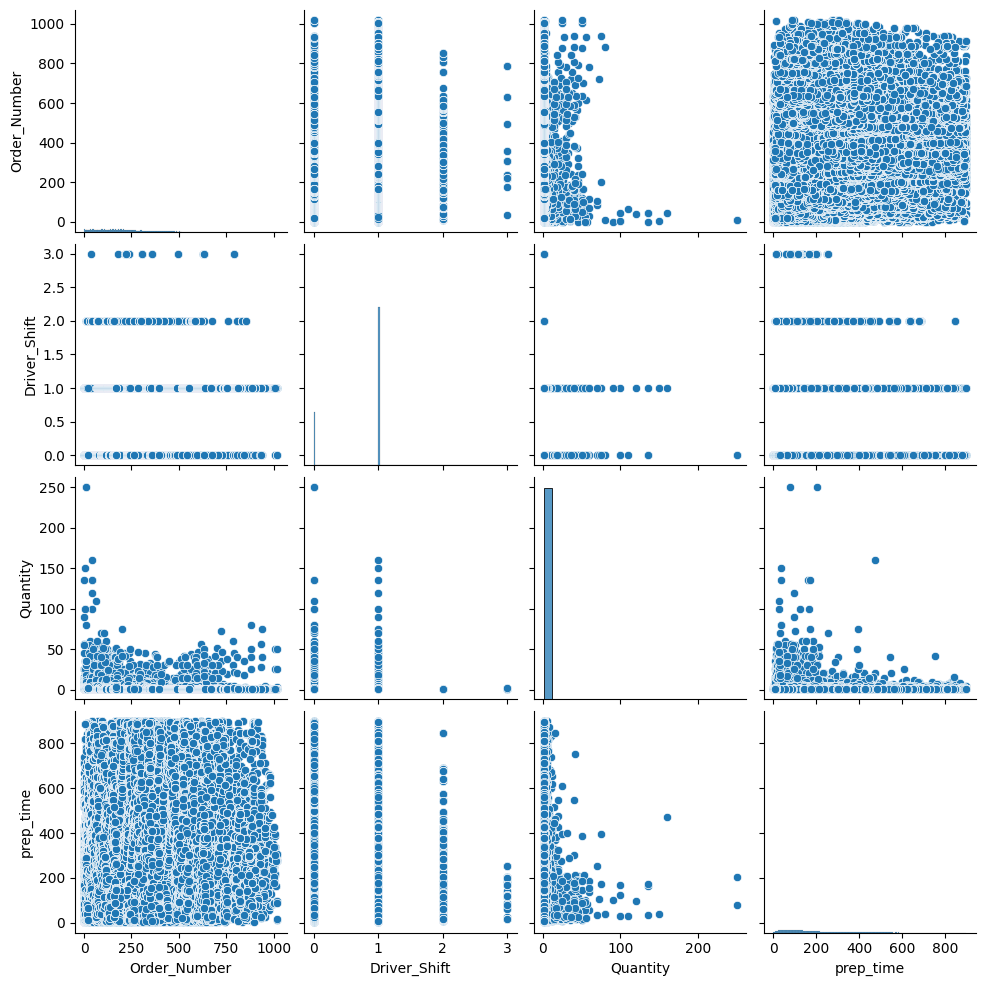

In [8]:
sns.pairplot(data=df)

<Axes: >

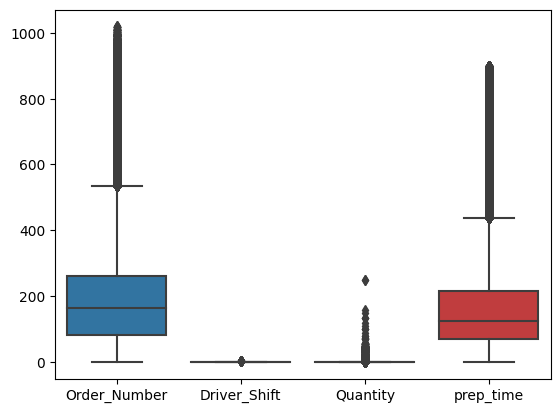

In [9]:
sns.boxplot(df)

In [10]:
allMenuCodes = df['Menu_Code'].unique()
allStoreIds = sorted(Counter(df['Location_Code'].values.tolist()), reverse=True)
# allMenuCodes,
# allStoreIds
print(len(allMenuCodes))
print(len(allStoreIds))

94
107


In [11]:
restWiseDFs = {}
for storeId in allStoreIds:
    restWiseDFs[storeId] = df.loc[df['Location_Code'] == storeId]

In [12]:
def get_preparation_time(item):
    return item['prep_time']

In [13]:
sampleItem=None
for index, item in df.iterrows():
    sampleItem = item
    break

In [14]:
# Feature 1: store id
def getOneHotEncodingStore(storeId, stores=allStoreIds):
    oneHotEncodingList = []
    for i in range(0, len(stores)):
        if stores[i] == storeId:
            oneHotEncodingList.append(1)
        else:
            oneHotEncodingList.append(0)
    return oneHotEncodingList

# returns the feature store id for an order
def getStoreId(item, isOneHotEncodingRequired=False):
    if isOneHotEncodingRequired:
        return getOneHotEncodingStore(item['Location_Code'], allStoreIds)
    else:
        for i in range(0, len(allStoreIds)):
            if item['Location_Code'] == allStoreIds[i]:
                return [i+1]
        return [-1]

In [15]:
# Feature 2 : Day of the week
def dayOfTheWeek(dt, isOneHotEncodingRequired=False):
    day = dt.weekday()
    if isOneHotEncodingRequired:
        days = [0, 0, 0, 0, 0, 0, 0]
        days[day] = 1
        return days
    else:
        return [day+1]

In [16]:
print(getStoreId(sampleItem))
print(getStoreId(sampleItem, True))

[100]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]


In [17]:
# Feature 3: TimeSlot of kitchen display time
total_slots = 24
def getTimeslot(dt, slots=total_slots):
	current = datetime(2011, 1, 1)
	t1 = current.time()
	t2 = dt.time()
	for i in range(0, slots):
		current = current + timedelta(minutes = 60*24/slots)
		if(current.time() > t2):
			return i
	return slots-1

def getOneHotEncodingTimeSlot(timeslot):
    oneHotEncodingList = []
    for i in range(0, 24):
        oneHotEncodingList.append(0)
    oneHotEncodingList[timeslot] = 1
    return oneHotEncodingList

def getTimeSlotOfKitchenDisplayTime(item, isOneHotEncodingRequired=False):
    timeslot = getTimeslot(item['Kitchen_Display_Time'], 24)
    if (isOneHotEncodingRequired):
        return getOneHotEncodingTimeSlot(timeslot)
    else:
        return [1+timeslot]

In [18]:
# Feature 4: Item Type
def getOneHotEncodedItemList(item, items=allMenuCodes, clubCategoryWise=False):
    if clubCategoryWise:
        newItemsList = []
        newItemsList = [i[0:3] for i in items]
        unique_items = list(dict.fromkeys(newItemsList))
        return getOneHotEncodedItemList(item[0:3], unique_items, False)
    
    oneHotEncodingList=[]
    for i in range(0, len(items)):
        if items[i] == item:
            oneHotEncodingList.append(1)
        else:
            oneHotEncodingList.append(0)
    return oneHotEncodingList

def getItemType(item, clubCategoryWise=False, isOneHotEncodingRequired=False):
    if isOneHotEncodingRequired:
        return getOneHotEncodedItemList(item['Menu_Code'], allMenuCodes, clubCategoryWise)
    else:
        for i in range(0, len(allMenuCodes)):
            if allMenuCodes[i] == item['Menu_Code']:
                return [i+1]
        print("DANGER DANGER DANGER \n\n\n")
        return [-1]

In [19]:
print(getItemType(sampleItem, False, True))
print(getItemType(sampleItem, True, False))
print(getItemType(sampleItem, clubCategoryWise=True))
print(getItemType(sampleItem, True))

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1]
[1]
[1]


In [20]:
# Feature 5 : Count of all baking items of all orders received by the store in the last 30 minutes.

def countPastOrders(item, slotTime=30):
    storeId = item['Location_Code']
    df = restWiseDFs[storeId]
    dtKitchenDisplay = item['Kitchen_Display_Time']
    lastTime = dtKitchenDisplay - timedelta(minutes=slotTime)
    return len(df.loc[(df['Kitchen_Display_Time'] >= lastTime) & \
          (df['Kitchen_Display_Time'] <= dtKitchenDisplay)].index)

In [21]:
# Feature 6: ratio of items in last 30 minutes with items in the window of last 60 to 30 minutes (increment in orders)
def getLiftInOrders(item, slotTime = 30):
    a = countPastOrders(item, slotTime)
    item2 = item
    item2['Kitchen_Display_Time'] = item2['Kitchen_Display_Time'] - timedelta(minutes=slotTime)
    b = countPastOrders(item2, slotTime)
    if b != 0:
        return a/b
    else:
        return 1


In [22]:
# TIME CONSUMING (4 m 14 seconds for Bhopal)
# Feature 7 : Avg prep time of the same item in the same store in last 60 minutes.
# Feature 8 : Avg prep time of the same item in the same store in last 7 days.
for storeId in restWiseDFs:
    avgPrepTime = restWiseDFs[storeId]['prep_time'].mean()    
    restWiseDFs[storeId]['avg_kpt_in_last_one_hour'] = 0 # to create a new column with initial values 0
    restWiseDFs[storeId]['avg_kpt_in_last_7_days'] = 0
    restWiseDFs[storeId]['hourswise_avg_kpt'] = 0
    for index, item in restWiseDFs[storeId].iterrows():
        itemCode = item['Menu_Code']
        dtKitchenDisplay = item['Kitchen_Display_Time']
        lastTimeMinutes = dtKitchenDisplay - timedelta(minutes=60)
        lastTime = dtKitchenDisplay - timedelta(days=7)
        df3 = restWiseDFs[storeId].loc[(restWiseDFs[storeId]['Kitchen_Display_Time'] >= lastTime) & \
                     (restWiseDFs[storeId]['Kitchen_Display_Time'] < dtKitchenDisplay) & \
                                 (restWiseDFs[storeId]['Menu_Code'] == itemCode)]
        df2 = df3.loc[df3['Kitchen_Display_Time'] >= lastTimeMinutes]
        if len(df2.index) != 0:
            restWiseDFs[storeId].at[index, 'avg_kpt_in_last_one_hour'] = df2['prep_time'].mean()
        else:
            restWiseDFs[storeId].at[index, 'avg_kpt_in_last_one_hour'] =  avgPrepTime
        if len(df3.index) != 0:
            restWiseDFs[storeId].at[index, 'avg_kpt_in_last_7_days'] = df3['prep_time'].mean()
        else:
            restWiseDFs[storeId].at[index, 'avg_kpt_in_last_7_days'] =  avgPrepTime


/tmp/ipykernel_229445/916470234.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_one_hour'] = 0 # to create a new column with initial values 0
/tmp/ipykernel_229445/916470234.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_7_days'] = 0
/tmp/ipykernel_229445/916470234.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

/tmp/ipykernel_229445/916470234.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_one_hour'] = 0 # to create a new column with initial values 0
/tmp/ipykernel_229445/916470234.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_7_days'] = 0
/tmp/ipykernel_229445/916470234.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

/tmp/ipykernel_229445/916470234.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_one_hour'] = 0 # to create a new column with initial values 0
/tmp/ipykernel_229445/916470234.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_7_days'] = 0
/tmp/ipykernel_229445/916470234.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

/tmp/ipykernel_229445/916470234.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_one_hour'] = 0 # to create a new column with initial values 0
/tmp/ipykernel_229445/916470234.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_7_days'] = 0
/tmp/ipykernel_229445/916470234.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

/tmp/ipykernel_229445/916470234.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_one_hour'] = 0 # to create a new column with initial values 0
/tmp/ipykernel_229445/916470234.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_7_days'] = 0
/tmp/ipykernel_229445/916470234.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

/tmp/ipykernel_229445/916470234.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_one_hour'] = 0 # to create a new column with initial values 0
/tmp/ipykernel_229445/916470234.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_7_days'] = 0
/tmp/ipykernel_229445/916470234.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

/tmp/ipykernel_229445/916470234.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_one_hour'] = 0 # to create a new column with initial values 0
/tmp/ipykernel_229445/916470234.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_7_days'] = 0
/tmp/ipykernel_229445/916470234.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

/tmp/ipykernel_229445/916470234.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_one_hour'] = 0 # to create a new column with initial values 0
/tmp/ipykernel_229445/916470234.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_7_days'] = 0
/tmp/ipykernel_229445/916470234.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

/tmp/ipykernel_229445/916470234.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_one_hour'] = 0 # to create a new column with initial values 0
/tmp/ipykernel_229445/916470234.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_7_days'] = 0
/tmp/ipykernel_229445/916470234.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

/tmp/ipykernel_229445/916470234.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_one_hour'] = 0 # to create a new column with initial values 0
/tmp/ipykernel_229445/916470234.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_7_days'] = 0
/tmp/ipykernel_229445/916470234.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

/tmp/ipykernel_229445/916470234.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_one_hour'] = 0 # to create a new column with initial values 0
/tmp/ipykernel_229445/916470234.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_7_days'] = 0
/tmp/ipykernel_229445/916470234.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

/tmp/ipykernel_229445/916470234.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_one_hour'] = 0 # to create a new column with initial values 0
/tmp/ipykernel_229445/916470234.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_7_days'] = 0
/tmp/ipykernel_229445/916470234.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

/tmp/ipykernel_229445/916470234.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_one_hour'] = 0 # to create a new column with initial values 0
/tmp/ipykernel_229445/916470234.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_7_days'] = 0
/tmp/ipykernel_229445/916470234.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

/tmp/ipykernel_229445/916470234.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_one_hour'] = 0 # to create a new column with initial values 0
/tmp/ipykernel_229445/916470234.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_7_days'] = 0
/tmp/ipykernel_229445/916470234.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

/tmp/ipykernel_229445/916470234.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_one_hour'] = 0 # to create a new column with initial values 0
/tmp/ipykernel_229445/916470234.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_7_days'] = 0
/tmp/ipykernel_229445/916470234.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

/tmp/ipykernel_229445/916470234.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_one_hour'] = 0 # to create a new column with initial values 0
/tmp/ipykernel_229445/916470234.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['avg_kpt_in_last_7_days'] = 0
/tmp/ipykernel_229445/916470234.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

In [23]:
def getPreviousPrepTime(item, timeslot = 60):
    if timeslot == 60:
        return item['avg_kpt_in_last_one_hour']
    elif timeslot == 7*24*60:
        return item['avg_kpt_in_last_7_days']
    else:
        itemCode = item['Menu_Code']
        df = restWiseDFs[item['Location_Code']]

        dtKitchenDisplay = item['Kitchen_Display_Time']

        lastTime = dtKitchenDisplay - timedelta(minutes=timeslot)

        df2 = df.loc[(df['Kitchen_Display_Time'] >= lastTime) & \
                     (df['Kitchen_Display_Time'] < dtKitchenDisplay) & \
                                 (df['Menu_Code'] == itemCode)]
        if len(df2.index) != 0:
            return df2['prep_time'].mean()
        else:
            return restWiseDFs[storeId]['prep_time'].mean()

In [24]:
# Hourwise avg
# Feature 9 : Avg prep time of the same item in same store : hour wise + according to the day of the week
hourWiseAvg = {}
for store in allStoreIds:
    hourWiseAvg[store] = {}
    for i in range(1, 8):
        hourWiseAvg[store][i] = {}

for storeId in allStoreIds:
    hwa = []
    for index, item in restWiseDFs[storeId].iterrows():
        ts = getTimeslot(item['Kitchen_Display_Time'])
        d = dayOfTheWeek(item['Kitchen_Display_Time'])[0]
        if ts not in hourWiseAvg[storeId][d]:
            hourWiseAvg[storeId][d][ts] = {'val': 0, 'cnt': 0}
        if hourWiseAvg[storeId][d][ts]['cnt'] == 0:
            hwa.append(item['avg_kpt_in_last_one_hour'])
        else:
            hwa.append(hourWiseAvg[storeId][d][ts]['val']/hourWiseAvg[storeId][d][ts]['cnt'])
        hourWiseAvg[storeId][d][ts]['val'] += item['prep_time']
        hourWiseAvg[storeId][d][ts]['cnt'] += 1

    restWiseDFs[storeId]['hour_wise_avg_kpt_of_the_day'] = hwa

/tmp/ipykernel_229445/2358782154.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['hour_wise_avg_kpt_of_the_day'] = hwa
/tmp/ipykernel_229445/2358782154.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['hour_wise_avg_kpt_of_the_day'] = hwa
/tmp/ipykernel_229445/2358782154.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

/tmp/ipykernel_229445/2358782154.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['hour_wise_avg_kpt_of_the_day'] = hwa
/tmp/ipykernel_229445/2358782154.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['hour_wise_avg_kpt_of_the_day'] = hwa
/tmp/ipykernel_229445/2358782154.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

/tmp/ipykernel_229445/2358782154.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['hour_wise_avg_kpt_of_the_day'] = hwa
/tmp/ipykernel_229445/2358782154.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['hour_wise_avg_kpt_of_the_day'] = hwa
/tmp/ipykernel_229445/2358782154.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

/tmp/ipykernel_229445/2358782154.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['hour_wise_avg_kpt_of_the_day'] = hwa
/tmp/ipykernel_229445/2358782154.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['hour_wise_avg_kpt_of_the_day'] = hwa
/tmp/ipykernel_229445/2358782154.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

/tmp/ipykernel_229445/2358782154.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['hour_wise_avg_kpt_of_the_day'] = hwa
/tmp/ipykernel_229445/2358782154.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId]['hour_wise_avg_kpt_of_the_day'] = hwa
/tmp/ipykernel_229445/2358782154.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

In [25]:
def getHourWiseAverage(item):
    return item["hour_wise_avg_kpt_of_the_day"]

In [26]:
# Feature 10 : Item quantity
def getQuantity(item):
    return item['Quantity']

In [27]:
# Feature 11 : Length of the queue in the store at that time
def lengthQueue(item):
    dtKitchenDisplay = item['Kitchen_Display_Time']
    d = restWiseDFs[item['Location_Code']]
    return len(d[(d['Oven_Time'] >= dtKitchenDisplay) & (d['Kitchen_Display_Time'] <= dtKitchenDisplay)].index)

In [28]:
sampleItem=None
for index, item in restWiseDFs[storeId].iterrows():
    sampleItem = item
    break

In [29]:
lengthQueue(sampleItem)

1

In [30]:
# global variables

clubItemsCategoryWise = False

splitMethod = 'initial 21 days'
slotTimeForPastOrders = 30 # minutes

model = 'xgboost'
isOneHotEncodingRequired = False
isNormalizationRequired = False

isCentralModel = True

In [31]:
def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

In [32]:
save_object(restWiseDFs, f'restWiseDFsBeforeFeatureCreation{city}.pkl')

In [33]:
totalFeatures = (0 + # store ID (categorical)
                1 + # day of the week (categorical)
                1 +  #timeslot of the day (categorical)
                0 +  # Item type (categorical)
                1 +  #count past orders in last 30 minutes
                1 +  #ratio lift in last 30 minutes
                1 + # average previous preparation time in last 1 hour
                1 + # average previous preparation time in last 7 days
                1 + # average kpt time, hour wise according to the day of the week
                0 + # Item quantity
                1) # length of the current queue

if isCentralModel:
    totalFeatures += 1
if isOneHotEncodingRequired:
    ##### DEPRECATED
    totalFeatures = (7 + # one hot encoded day of the week
                 len(allMenuCodes) +  # Item type
                24 +  #timeslot of the day
                1 +  #count past orders
                1 +  #lift in last 30 minutes
                1 + # average previous preparation time in last 1 hour
                1 + # average previous preparation time in last 7 days
                1) # length of the current queue
    if isCentralModel:
        totalFeatures += len(allStoreIds)

feature_cols = []
for i in range(0, totalFeatures):
    feature_cols.append('feature_'+str(i+1))

In [34]:
def updateFeatures(storeId, Xnp, fc=feature_cols):
    restWiseDFs[storeId][fc] = Xnp

In [35]:
# TIME CONSUMING (3m 21s for Bhopal) 46 minutes for Delhi december
for storeId in restWiseDFs:
    X = []
    df = restWiseDFs[storeId]
    for index, item in df.iterrows():
        features = getStoreId(item, False)
        features += dayOfTheWeek(item['Kitchen_Display_Time'], isOneHotEncodingRequired)
        features += getTimeSlotOfKitchenDisplayTime(item, isOneHotEncodingRequired)
#         features += getItemType(item, clubItemsCategoryWise, isOneHotEncodingRequired)
        features += [countPastOrders(item, slotTimeForPastOrders)]
        features += [getLiftInOrders(item, slotTimeForPastOrders)]
        features += [getPreviousPrepTime(item, timeslot = 60)]
        features += [getPreviousPrepTime(item, timeslot = 7*24*60)]
        features += [getHourWiseAverage(item)]
#         features += [getQuantity(item)]
        features += [lengthQueue(item)]
        X.append(features)
    Xnp = np.array(X)
    updateFeatures(storeId, Xnp)
    print(Xnp.shape)

/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(6092, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(12406, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(8465, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(9418, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(8791, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(5897, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(12079, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(9223, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(3558, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(12496, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(10427, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(10093, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(4192, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(9594, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(12679, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(10928, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(9321, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(14375, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(7543, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(11908, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(13444, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(12948, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(10155, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(14077, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(8876, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(11454, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(10091, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(13881, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(8979, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(12769, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(16371, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(13707, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(12664, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(8052, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(15354, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(11744, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(9462, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(10887, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(13190, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(11117, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(19359, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(10766, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(7742, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(15375, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(13897, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(15247, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(13439, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(19601, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(11374, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(11006, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(11100, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(11617, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(12324, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(19400, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(16162, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(8343, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(16176, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(9053, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(16316, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(10412, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(10252, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(5340, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(15003, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(15524, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(14652, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(12247, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(13259, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(11460, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(8208, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(8980, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(14266, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(9329, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(12254, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(9855, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(12608, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(16079, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(15195, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(10564, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(13259, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(11110, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(11218, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(7492, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(12545, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(21716, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(11725, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(8705, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(16149, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(14252, 9)
(36, 9)
(204, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(7036, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(6994, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(8016, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(5825, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(7027, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(8524, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(7711, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(12316, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(11035, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(4487, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(10864, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(8490, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(11217, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(3078, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(7562, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

(11297, 9)
(9101, 9)


/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][fc] = Xnp
/tmp/ipykernel_229445/2517518382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

In [36]:
# categorical data
if not isOneHotEncodingRequired:
    for i in range(0, 3):
        for storeId in allStoreIds:
            restWiseDFs[storeId][feature_cols[i]] = restWiseDFs[storeId][feature_cols[i]].astype("category")

/tmp/ipykernel_229445/1019853123.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][feature_cols[i]] = restWiseDFs[storeId][feature_cols[i]].astype("category")
/tmp/ipykernel_229445/1019853123.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][feature_cols[i]] = restWiseDFs[storeId][feature_cols[i]].astype("category")
/tmp/ipykernel_229445/1019853123.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

/tmp/ipykernel_229445/1019853123.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][feature_cols[i]] = restWiseDFs[storeId][feature_cols[i]].astype("category")
/tmp/ipykernel_229445/1019853123.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restWiseDFs[storeId][feature_cols[i]] = restWiseDFs[storeId][feature_cols[i]].astype("category")
/tmp/ipykernel_229445/1019853123.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

In [37]:
save_object(restWiseDFs, 'WithoutNormalization.pkl')

In [38]:
restWiseScalers = {}

# normalize feature values
if isNormalizationRequired:
    for storeId in allStoreIds:
        firstTime = datetime(2022, 7, 1)
        lastTime = datetime(2022, 7, 21)
        trainingData = restWiseDFs[storeId].loc[(restWiseDFs[storeId]['Kitchen_Display_Time'] >= firstTime) & \
              (restWiseDFs[storeId]['Kitchen_Display_Time'] <= lastTime)].loc[:, feature_cols[4:]]
        scaler = StandardScaler()
        scaler.fit(trainingData)
        if isNormalizationRequired:
            X = restWiseDFs[storeId].loc[:, feature_cols[3:]]
            X_scaled = scaler.transform(X)
            X_scalednp = np.array(X_scaled)
            restWiseDFs[storeId][feature_cols[3:]] = X_scalednp
    save_object(restWiseDFs, f'restWiseDFsWithNormalizedFeatures{city}.pkl')

In [39]:
def getRMSE(actual, predictions):
    mse = sklearn.metrics.mean_squared_error(actual, predictions)
    return math.sqrt(mse)

In [40]:
if isCentralModel:
    overallDF = pd.DataFrame()
    for storeId in allStoreIds:
        overallDF = pd.concat([overallDF, restWiseDFs[storeId]], ignore_index=True)
        
    firstTimeTrain = datetime(2021, 12, 1)
    lastTimeTrain = datetime(2021, 12, 23) + timedelta(days=1)
    
    firstTimeVal = datetime(2021, 12, 24)
    lastTimeVal = datetime(2021, 12, 31) + timedelta(days=1)
    
    firstTimeTest = datetime(2021, 12, 24)
    lastTimeTest = datetime(2021, 12, 31) + timedelta(days=1)

    trainingData = overallDF.loc[(overallDF['Kitchen_Display_Time'] >= firstTimeTrain) & \
          (overallDF['Kitchen_Display_Time'] < lastTimeTrain)]
    X_train = trainingData.loc[:, feature_cols]
    y_train = trainingData.prep_time.values.tolist()

    validationData = overallDF.loc[(overallDF['Kitchen_Display_Time'] >= firstTimeVal) & \
          (overallDF['Kitchen_Display_Time'] <= lastTimeVal)]

    X_train_val = validationData.loc[:, feature_cols]
    y_train_val = validationData.prep_time.values.tolist()

    testData = overallDF.loc[(overallDF['Kitchen_Display_Time'] >= firstTimeTest) & \
          (overallDF['Kitchen_Display_Time'] <= lastTimeTest)]

    X_test = testData.loc[:, feature_cols]
    y_test = testData.prep_time.values.tolist()
    print("TRAIN TEST SPLITED")


    regressor = XGBRegressor()
    param_grid = {
        'tree_method': ['hist'],
        'n_estimators': [100, 150],
        'learning_rate': [0.08],
        'subsample': [0.6, 0.7, 0.8],
        'enable_categorical': [True],
        'colsample_bytree': [0.6, 0.7, 0.8],
        'max_depth': [5, 6, 7],
    }
    
    {'colsample_bytree': 0.8, 'enable_categorical': True, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.9, 'tree_method': 'hist'}

    # define the GridSearchCV object with the parameter grid and the XGBRegressor model
    grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=5)
    
    print("FITTING TO GRID SEARCH START")
    # fit the GridSearchCV object on the training set
    grid_search.fit(X_train, y_train)

    # print the best hyperparameters and the corresponding mean cross-validated score
    print("Best hyperparameters:", grid_search.best_params_)
    print("Best mean cross-validated score:", grid_search.best_score_)
    

    # retrain the model on the combined training and validation sets with the best hyperparameters
    best_regressor = XGBRegressor(**grid_search.best_params_)
    best_regressor.fit(X_train, y_train)
    
    print("MODEL PREPARED")
    # evaluate the final model performance on the test set
    test_score = best_regressor.score(X_train_val, y_train_val)
    print("Test score:", test_score)

    overallPredictions = best_regressor.predict(overallDF.loc[:, feature_cols])
    overallDF['predicted_prep_time_central'] = overallPredictions
    
    trainingData = overallDF.loc[(overallDF['Kitchen_Display_Time'] >= firstTimeTrain) & \
          (overallDF['Kitchen_Display_Time'] < lastTimeTrain)]
    X_train = trainingData.loc[:, feature_cols]
    y_train = trainingData.prep_time.values.tolist()

    validationData = overallDF.loc[(overallDF['Kitchen_Display_Time'] >= firstTimeVal) & \
          (overallDF['Kitchen_Display_Time'] <= lastTimeVal)]

    X_train_val = validationData.loc[:, feature_cols]
    y_train_val = validationData.prep_time.values.tolist()

    testData = overallDF.loc[(overallDF['Kitchen_Display_Time'] >= firstTimeTest) & \
          (overallDF['Kitchen_Display_Time'] <= lastTimeTest)]

    X_test = testData.loc[:, feature_cols]
    y_test = testData.prep_time.values.tolist()


    print("ACCURACY ON Train DATA : ")
    print("RMSE score: ", getRMSE(trainingData.prep_time.values.tolist(), best_regressor.predict(trainingData.loc[:, feature_cols])))
        
#     print("ACCURACY ON Validation DATA : ")
#     print("RMSE score: ", getRMSE(validationData.prep_time.values.tolist(), best_regressor.predict(validationData.loc[:, feature_cols])))

    print("ACCURACY ON Test DATA : ")
    print("RMSE score: ", getRMSE(testData.prep_time.values.tolist(), best_regressor.predict(testData.loc[:, feature_cols])))
    

    

TRAIN TEST SPLITED
FITTING TO GRID SEARCH START
Best hyperparameters: {'colsample_bytree': 0.6, 'enable_categorical': True, 'learning_rate': 0.08, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8, 'tree_method': 'hist'}
Best mean cross-validated score: 0.38796176418770517
MODEL PREPARED
Test score: 0.36442920755968455
ACCURACY ON Train DATA : 
RMSE score:  78.61397887487927
ACCURACY ON Test DATA : 
RMSE score:  124.97446638125162


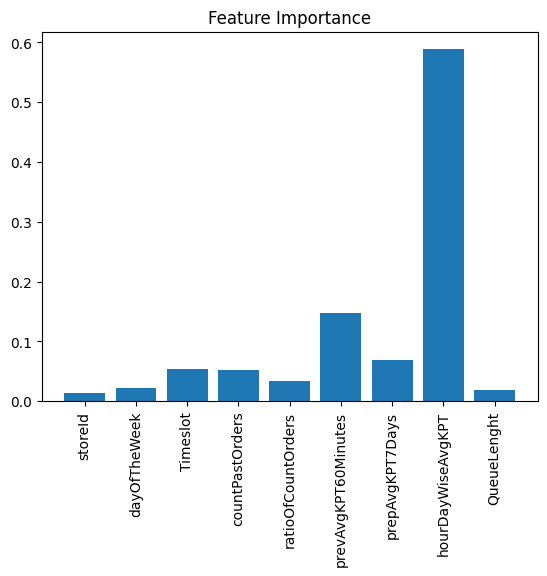

1.0000000325962901


In [41]:
f = ['storeId', 'dayOfTheWeek', 'Timeslot', 'countPastOrders', 'ratioOfCountOrders', 'prevAvgKPT60Minutes', 'prepAvgKPT7Days', 'hourDayWiseAvgKPT', 'QueueLenght']
pyplot.bar(f, best_regressor.feature_importances_)
pyplot.xticks(rotation=90)
pyplot.title("Feature Importance")
pyplot.show()
print(sum(best_regressor.feature_importances_))

In [42]:
allDays = overallDF.Order_Date.unique()
for storeId in allStoreIds:
    df = overallDF.loc[overallDF['Location_Code'] == storeId]
    diffs = []
    for day in allDays:
        df2 = df.loc[df['Order_Date'] == day]
        timeslots = df2.feature_3.unique()
        for ts in sorted(timeslots):
            df3 = df2.loc[df2['feature_3'] == ts]
            l1 = df3.prep_time.values.tolist()
            l2 = df3.predicted_prep_time_central.values.tolist()
            l3 = df3.hour_wise_avg_kpt_of_the_day.values.tolist()
            rmseModel = getRMSE(l1, l2)
            rmseBaseline = getRMSE(l1, l3)
#             print(f"{day} \t {ts} \t {rmseModel} \t {rmseBaseline}")
            diffs.append(rmseModel-rmseBaseline)
# print(sorted(diffs))
diffs = sorted(diffs)
print(f"lowest: {diffs[0]}, highest: {diffs[len(diffs)-1]}, median: {diffs[len(diffs)//2]}")


lowest: -95.21894354620252, highest: 94.85554589471542, median: -3.4842716214818807


In [45]:
def getMAE(actual, predictions):
    mse = sklearn.metrics.mean_absolute_error(actual, predictions)
    return mse

def getSTD(actual, predictions):
    a = []
    for i in range(0, len(actual)):
        a.append(abs(actual[i]-predictions[i]))
    return np.std(a)

def getDayOfTheWeek(a):
    if a==1:
        return "Monday"
    if a==2:
        return "Tuesday"
    if a==3:
        return "Wednesday"
    if a==4:
        return "Thursday"
    if a==5:
        return "Friday"
    if a==6:
        return "Saturday"
    if a==7:
        return "Sunday"

In [ ]:
dfError = pd.DataFrame()
allDays = overallDF.Order_Date.unique()
for storeId in allStoreIds:
# for i in range(0, 1):
    df = overallDF.loc[overallDF['Location_Code'] == storeId]
    diffs = []
    for day in allDays:
        df2 = df.loc[df['Order_Date'] == day]
        for ts in sorted(timeslots):
            df3 = df2.loc[df['feature_3'] == ts]
            if(df3.size == 0):
                continue
            rmseModel = getRMSE(df3.prep_time.values.tolist(), df3.predicted_prep_time_central.values.tolist())
            rmseBaseline = getRMSE(df3.prep_time.values.tolist(), df3.hour_wise_avg_kpt_of_the_day.values.tolist())

            maeModel = getMAE(df3.prep_time.values.tolist(), df3.predicted_prep_time_central.values.tolist())
            maeBaseline = getMAE(df3.prep_time.values.tolist(), df3.hour_wise_avg_kpt_of_the_day.values.tolist())
            
            stdModel = getSTD(df3.prep_time.values.tolist(), df3.predicted_prep_time_central.values.tolist())
            stdBaseline = getSTD(df3.prep_time.values.tolist(), df3.hour_wise_avg_kpt_of_the_day.values.tolist())

            weekday = datetime.strptime(day, "%Y-%m-%d").weekday()+1
            a = {"storeId":[storeId], "date":[day], "timeslot":ts, "weekday": [getDayOfTheWeek(weekday)], "total_orders":[df3.size], "mean_kpt":[np.mean(df3.prep_time.values.tolist())], "std_kpt":[np.std(df3.prep_time.values.tolist())], "model rmse": [rmseModel], "baseline rmse": [rmseBaseline], "model mae": [maeModel], "baseline mae": [maeBaseline], "model std AE": [stdModel], "baseline std AE": [stdBaseline]}
            print(a)
            b = pd.DataFrame(a)
            dfError = pd.concat([dfError, b], ignore_index= True)
        
        

{'storeId': ['DPI67255'], 'date': ['2021-12-17'], 'timeslot': 12.0, 'weekday': ['Friday'], 'total_orders': [225], 'mean_kpt': [101.14466666666667], 'std_kpt': [68.59711440966983], 'model rmse': [77.39700740313785], 'baseline rmse': [87.86770011214332], 'model mae': [64.77667993164063], 'baseline mae': [73.91372966645474], 'model std AE': [42.35892458496984], 'baseline std AE': [47.51308545855341]}
{'storeId': ['DPI67255'], 'date': ['2021-12-17'], 'timeslot': 13.0, 'weekday': ['Friday'], 'total_orders': [350], 'mean_kpt': [74.80507142857142], 'std_kpt': [33.50167646010801], 'model rmse': [35.89468061256607], 'baseline rmse': [38.650237589251525], 'model mae': [29.52438417271205], 'baseline mae': [31.057209266216464], 'model std AE': [20.414182214828898], 'baseline std AE': [23.00631692166371]}
{'storeId': ['DPI67255'], 'date': ['2021-12-17'], 'timeslot': 14.0, 'weekday': ['Friday'], 'total_orders': [300], 'mean_kpt': [121.21800000000002], 'std_kpt': [88.76055216329681], 'model rmse': [9

{'storeId': ['DPI67255'], 'date': ['2021-12-24'], 'timeslot': 12.0, 'weekday': ['Friday'], 'total_orders': [200], 'mean_kpt': [53.999249999999996], 'std_kpt': [17.272136128386087], 'model rmse': [42.203323602502834], 'baseline rmse': [40.15277004871982], 'model mae': [36.52315371704101], 'baseline mae': [33.12857712599901], 'model std AE': [21.146625396477937], 'baseline std AE': [22.687933360976437]}
{'storeId': ['DPI67255'], 'date': ['2021-12-24'], 'timeslot': 13.0, 'weekday': ['Friday'], 'total_orders': [75], 'mean_kpt': [34.727666666666664], 'std_kpt': [2.0441111080912933], 'model rmse': [42.48044983135032], 'baseline rmse': [37.625757370636244], 'model mae': [42.47271683756511], 'baseline mae': [37.60954186507936], 'model std AE': [0.8105197776027883], 'baseline std AE': [1.1045263296231365]}
{'storeId': ['DPI67255'], 'date': ['2021-12-24'], 'timeslot': 14.0, 'weekday': ['Friday'], 'total_orders': [950], 'mean_kpt': [136.24805263157896], 'std_kpt': [78.24721729403792], 'model rmse

{'storeId': ['DPI67233'], 'date': ['2021-12-17'], 'timeslot': 12.0, 'weekday': ['Friday'], 'total_orders': [225], 'mean_kpt': [56.05688888888889], 'std_kpt': [9.800718255362087], 'model rmse': [39.410686045296664], 'baseline rmse': [59.75983585709401], 'model mae': [23.182413428412545], 'baseline mae': [25.86713195040461], 'model std AE': [31.871270482914532], 'baseline std AE': [53.87141604160017]}
{'storeId': ['DPI67233'], 'date': ['2021-12-17'], 'timeslot': 13.0, 'weekday': ['Friday'], 'total_orders': [650], 'mean_kpt': [42.90511538461538], 'std_kpt': [33.020783661817184], 'model rmse': [32.63021827464428], 'baseline rmse': [34.13059859728454], 'model mae': [28.857427482018103], 'baseline mae': [22.211134429296887], 'model std AE': [15.230890445768292], 'baseline std AE': [25.91453777269939]}
{'storeId': ['DPI67233'], 'date': ['2021-12-17'], 'timeslot': 14.0, 'weekday': ['Friday'], 'total_orders': [875], 'mean_kpt': [36.40528571428571], 'std_kpt': [20.17375934025107], 'model rmse': 

{'storeId': ['DPI67233'], 'date': ['2021-12-23'], 'timeslot': 20.0, 'weekday': ['Thursday'], 'total_orders': [1625], 'mean_kpt': [128.24733846153848], 'std_kpt': [92.00728617105477], 'model rmse': [76.81246173079654], 'baseline rmse': [93.1431169950783], 'model mae': [60.92956394653321], 'baseline mae': [69.81378739687987], 'model std AE': [46.7733098511363], 'baseline std AE': [61.657727276166305]}
{'storeId': ['DPI67233'], 'date': ['2021-12-23'], 'timeslot': 21.0, 'weekday': ['Thursday'], 'total_orders': [2250], 'mean_kpt': [118.81224444444446], 'std_kpt': [47.89404665655479], 'model rmse': [68.25899633172476], 'baseline rmse': [49.09299856261346], 'model mae': [55.134157400173606], 'baseline mae': [41.25181625076096], 'model std AE': [40.24320151264428], 'baseline std AE': [26.615975726661247]}
{'storeId': ['DPI67233'], 'date': ['2021-12-24'], 'timeslot': 12.0, 'weekday': ['Friday'], 'total_orders': [225], 'mean_kpt': [18.84888888888889], 'std_kpt': [3.38236591897987], 'model rmse':

{'storeId': ['DPI67233'], 'date': ['2021-12-30'], 'timeslot': 21.0, 'weekday': ['Thursday'], 'total_orders': [3300], 'mean_kpt': [407.2815378787879], 'std_kpt': [127.8179853253935], 'model rmse': [193.53028677311332], 'baseline rmse': [224.54054956782772], 'model mae': [166.01904156679097], 'baseline mae': [196.3840676714608], 'model std AE': [99.45677320186702], 'baseline std AE': [108.86577223826228]}
{'storeId': ['DPI67233'], 'date': ['2021-12-31'], 'timeslot': 12.0, 'weekday': ['Friday'], 'total_orders': [700], 'mean_kpt': [63.658785714285706], 'std_kpt': [27.591474119679415], 'model rmse': [28.841110169694222], 'baseline rmse': [32.63381176283449], 'model mae': [25.688776850019178], 'baseline mae': [28.912197348293883], 'model std AE': [13.110925969219645], 'baseline std AE': [15.134414909913858]}
{'storeId': ['DPI67233'], 'date': ['2021-12-31'], 'timeslot': 13.0, 'weekday': ['Friday'], 'total_orders': [775], 'mean_kpt': [98.79125806451614], 'std_kpt': [50.36036889867688], 'model 

{'storeId': ['DPI67227'], 'date': ['2021-12-21'], 'timeslot': 16.0, 'weekday': ['Tuesday'], 'total_orders': [1175], 'mean_kpt': [132.52636170212767], 'std_kpt': [58.47826561135106], 'model rmse': [61.49756140642584], 'baseline rmse': [62.051712954030094], 'model mae': [50.766678158374546], 'baseline mae': [51.67860663357247], 'model std AE': [34.708708528280525], 'baseline std AE': [34.34729533663204]}
{'storeId': ['DPI67227'], 'date': ['2021-12-21'], 'timeslot': 17.0, 'weekday': ['Tuesday'], 'total_orders': [825], 'mean_kpt': [117.04409090909091], 'std_kpt': [47.630944502538014], 'model rmse': [49.48890627845443], 'baseline rmse': [48.94816936961568], 'model mae': [30.524227742513016], 'baseline mae': [29.87344755864896], 'model std AE': [38.954118721398956], 'baseline std AE': [38.77499729977079]}
{'storeId': ['DPI67227'], 'date': ['2021-12-21'], 'timeslot': 18.0, 'weekday': ['Tuesday'], 'total_orders': [525], 'mean_kpt': [80.88795238095238], 'std_kpt': [40.1052053912447], 'model rms

{'storeId': ['DPI67227'], 'date': ['2021-12-28'], 'timeslot': 19.0, 'weekday': ['Tuesday'], 'total_orders': [1650], 'mean_kpt': [108.42557575757577], 'std_kpt': [46.12902458291887], 'model rmse': [62.77032529902657], 'baseline rmse': [48.51876118207564], 'model mae': [54.101410200639194], 'baseline mae': [42.370801892714965], 'model std AE': [31.83003538244636], 'baseline std AE': [23.638640688745042]}
{'storeId': ['DPI67227'], 'date': ['2021-12-28'], 'timeslot': 20.0, 'weekday': ['Tuesday'], 'total_orders': [2175], 'mean_kpt': [223.38048275862073], 'std_kpt': [85.25111434305396], 'model rmse': [97.12529117468328], 'baseline rmse': [112.54378099725167], 'model mae': [85.22924327350485], 'baseline mae': [97.39016586273674], 'model std AE': [46.5757262615704], 'baseline std AE': [56.40264385989344]}
{'storeId': ['DPI67227'], 'date': ['2021-12-28'], 'timeslot': 21.0, 'weekday': ['Tuesday'], 'total_orders': [1875], 'mean_kpt': [206.82717333333335], 'std_kpt': [114.35200626047897], 'model r

{'storeId': ['DPI67177'], 'date': ['2021-12-18'], 'timeslot': 18.0, 'weekday': ['Saturday'], 'total_orders': [1125], 'mean_kpt': [86.16333333333334], 'std_kpt': [36.299219200662954], 'model rmse': [37.35823626195697], 'baseline rmse': [37.96780337135853], 'model mae': [31.326321038140193], 'baseline mae': [32.68770146676475], 'model std AE': [20.354346632097325], 'baseline std AE': [19.314975166067633]}
{'storeId': ['DPI67177'], 'date': ['2021-12-18'], 'timeslot': 19.0, 'weekday': ['Saturday'], 'total_orders': [1350], 'mean_kpt': [154.77203703703705], 'std_kpt': [130.48436120626116], 'model rmse': [130.1791405581582], 'baseline rmse': [132.78409272764145], 'model mae': [91.35879272460937], 'baseline mae': [92.62088846279711], 'model std AE': [92.73715344112397], 'baseline std AE': [95.14718231174783]}
{'storeId': ['DPI67177'], 'date': ['2021-12-18'], 'timeslot': 20.0, 'weekday': ['Saturday'], 'total_orders': [2100], 'mean_kpt': [80.3305357142857], 'std_kpt': [41.32775337799689], 'model

{'storeId': ['DPI67177'], 'date': ['2021-12-25'], 'timeslot': 21.0, 'weekday': ['Saturday'], 'total_orders': [6600], 'mean_kpt': [174.88613257575756], 'std_kpt': [90.1730611218909], 'model rmse': [93.6252228172563], 'baseline rmse': [98.76995416880484], 'model mae': [74.48912136563388], 'baseline mae': [72.19963992384304], 'model std AE': [56.71907215176177], 'baseline std AE': [67.39967241296665]}
{'storeId': ['DPI67177'], 'date': ['2021-12-26'], 'timeslot': 12.0, 'weekday': ['Sunday'], 'total_orders': [175], 'mean_kpt': [82.63714285714286], 'std_kpt': [36.29757287607365], 'model rmse': [42.68816273685831], 'baseline rmse': [47.04527852817206], 'model mae': [30.759579877580915], 'baseline mae': [35.480833757396354], 'model std AE': [29.599450731444623], 'baseline std AE': [30.8928578748113]}
{'storeId': ['DPI67177'], 'date': ['2021-12-26'], 'timeslot': 13.0, 'weekday': ['Sunday'], 'total_orders': [350], 'mean_kpt': [90.65307142857144], 'std_kpt': [15.320907724247212], 'model rmse': [2

{'storeId': ['DPI67151'], 'date': ['2021-12-17'], 'timeslot': 12.0, 'weekday': ['Friday'], 'total_orders': [100], 'mean_kpt': [80.45075], 'std_kpt': [22.32496273653105], 'model rmse': [23.34757742373991], 'baseline rmse': [38.21616661787316], 'model mae': [17.818055770874025], 'baseline mae': [27.06001955124559], 'model std AE': [15.087288030111724], 'baseline std AE': [26.9857505519348]}
{'storeId': ['DPI67151'], 'date': ['2021-12-17'], 'timeslot': 13.0, 'weekday': ['Friday'], 'total_orders': [325], 'mean_kpt': [127.83784615384614], 'std_kpt': [76.81480666046113], 'model rmse': [76.43330052061258], 'baseline rmse': [93.67874686456682], 'model mae': [65.89280752563477], 'baseline mae': [69.97658185425685], 'model std AE': [38.73225199835306], 'baseline std AE': [62.28150292109269]}
{'storeId': ['DPI67151'], 'date': ['2021-12-17'], 'timeslot': 14.0, 'weekday': ['Friday'], 'total_orders': [525], 'mean_kpt': [91.15833333333333], 'std_kpt': [50.882343101122196], 'model rmse': [50.995986437

{'storeId': ['DPI67151'], 'date': ['2021-12-25'], 'timeslot': 16.0, 'weekday': ['Saturday'], 'total_orders': [3850], 'mean_kpt': [209.52894155844157], 'std_kpt': [131.96694919036912], 'model rmse': [115.51218908130747], 'baseline rmse': [136.47264307064907], 'model mae': [108.05511884377219], 'baseline mae': [123.53871619731524], 'model std AE': [40.830835382269555], 'baseline std AE': [57.991101964077046]}
{'storeId': ['DPI67151'], 'date': ['2021-12-25'], 'timeslot': 17.0, 'weekday': ['Saturday'], 'total_orders': [1625], 'mean_kpt': [126.67573846153847], 'std_kpt': [65.6894207783349], 'model rmse': [87.78812768941009], 'baseline rmse': [110.09505363057774], 'model mae': [71.40961214505708], 'baseline mae': [92.67216545516793], 'model std AE': [51.06292839726962], 'baseline std AE': [59.437282775794614]}
{'storeId': ['DPI67151'], 'date': ['2021-12-25'], 'timeslot': 18.0, 'weekday': ['Saturday'], 'total_orders': [3300], 'mean_kpt': [168.75762121212122], 'std_kpt': [79.1995057321708], 'm

{'storeId': ['DPI67150'], 'date': ['2021-12-17'], 'timeslot': 12.0, 'weekday': ['Friday'], 'total_orders': [125], 'mean_kpt': [26.6738], 'std_kpt': [5.78259033306009], 'model rmse': [13.939061830183936], 'baseline rmse': [18.38336045483865], 'model mae': [7.555203695678711], 'baseline mae': [13.423186682493924], 'model std AE': [11.713937929769543], 'baseline std AE': [12.5604936566778]}
{'storeId': ['DPI67150'], 'date': ['2021-12-17'], 'timeslot': 13.0, 'weekday': ['Friday'], 'total_orders': [375], 'mean_kpt': [36.54766666666667], 'std_kpt': [17.02975362776051], 'model rmse': [19.72431442545123], 'baseline rmse': [20.91131068509305], 'model mae': [18.81609884236654], 'baseline mae': [18.772355404225404], 'model std AE': [5.916333654245348], 'baseline std AE': [9.21312038051907]}
{'storeId': ['DPI67150'], 'date': ['2021-12-17'], 'timeslot': 14.0, 'weekday': ['Friday'], 'total_orders': [1275], 'mean_kpt': [35.857392156862744], 'std_kpt': [27.58057365004979], 'model rmse': [30.7937265332

{'storeId': ['DPI67150'], 'date': ['2021-12-24'], 'timeslot': 15.0, 'weekday': ['Friday'], 'total_orders': [425], 'mean_kpt': [98.73429411764705], 'std_kpt': [72.49747108024626], 'model rmse': [84.53084497124111], 'baseline rmse': [85.98428628767009], 'model mae': [59.068338014490465], 'baseline mae': [59.765724457017825], 'model std AE': [60.46813372147267], 'baseline std AE': [61.81711468944368]}
{'storeId': ['DPI67150'], 'date': ['2021-12-24'], 'timeslot': 16.0, 'weekday': ['Friday'], 'total_orders': [4575], 'mean_kpt': [36.96344808743169], 'std_kpt': [12.560497024566173], 'model rmse': [33.61642866588299], 'baseline rmse': [12.689649455002767], 'model mae': [31.16746443901688], 'baseline mae': [7.95482157769991], 'model std AE': [12.595770587424115], 'baseline std AE': [9.88675967937989]}
{'storeId': ['DPI67150'], 'date': ['2021-12-24'], 'timeslot': 17.0, 'weekday': ['Friday'], 'total_orders': [2475], 'mean_kpt': [59.4199595959596], 'std_kpt': [49.604947230246495], 'model rmse': [5

{'storeId': ['DPI67150'], 'date': ['2021-12-31'], 'timeslot': 19.0, 'weekday': ['Friday'], 'total_orders': [1675], 'mean_kpt': [61.50429850746269], 'std_kpt': [36.3456237723805], 'model rmse': [35.371142074169875], 'baseline rmse': [40.75400262804261], 'model mae': [25.899074476555214], 'baseline mae': [29.87799669741007], 'model std AE': [24.090571452104598], 'baseline std AE': [27.716313671844194]}
{'storeId': ['DPI67150'], 'date': ['2021-12-31'], 'timeslot': 20.0, 'weekday': ['Friday'], 'total_orders': [2425], 'mean_kpt': [56.923649484536085], 'std_kpt': [37.249696449338494], 'model rmse': [38.79466021674156], 'baseline rmse': [37.51372506814773], 'model mae': [27.71696912218861], 'baseline mae': [24.444242046289144], 'model std AE': [27.143973253966973], 'baseline std AE': [28.45625764697468]}
{'storeId': ['DPI67150'], 'date': ['2021-12-31'], 'timeslot': 21.0, 'weekday': ['Friday'], 'total_orders': [1075], 'mean_kpt': [69.83523255813954], 'std_kpt': [36.572444324284554], 'model rms

{'storeId': ['DPI67132'], 'date': ['2021-12-24'], 'timeslot': 12.0, 'weekday': ['Friday'], 'total_orders': [225], 'mean_kpt': [65.55355555555555], 'std_kpt': [18.600694002053384], 'model rmse': [19.403827247871096], 'baseline rmse': [25.913759759124858], 'model mae': [15.366417188856335], 'baseline mae': [22.384104497354496], 'model std AE': [11.84827981789953], 'baseline std AE': [13.056600273622264]}
{'storeId': ['DPI67132'], 'date': ['2021-12-24'], 'timeslot': 13.0, 'weekday': ['Friday'], 'total_orders': [875], 'mean_kpt': [136.1579142857143], 'std_kpt': [69.46796065252833], 'model rmse': [81.37003639854119], 'baseline rmse': [81.36228526026164], 'model mae': [63.94882677873883], 'baseline mae': [64.31965859261385], 'model std AE': [50.31530956997851], 'baseline std AE': [49.82773305401101]}
{'storeId': ['DPI67132'], 'date': ['2021-12-24'], 'timeslot': 14.0, 'weekday': ['Friday'], 'total_orders': [1950], 'mean_kpt': [140.38423076923075], 'std_kpt': [68.44276298089935], 'model rmse':

{'storeId': ['DPI67132'], 'date': ['2021-12-30'], 'timeslot': 21.0, 'weekday': ['Thursday'], 'total_orders': [2900], 'mean_kpt': [78.53731896551724], 'std_kpt': [36.34543799257891], 'model rmse': [45.01142195998761], 'baseline rmse': [43.07424776208995], 'model mae': [37.214945878653694], 'baseline mae': [34.9609496041889], 'model std AE': [25.319476892482026], 'baseline std AE': [25.161932021275238]}
{'storeId': ['DPI67132'], 'date': ['2021-12-31'], 'timeslot': 12.0, 'weekday': ['Friday'], 'total_orders': [400], 'mean_kpt': [70.7724375], 'std_kpt': [30.257577441379766], 'model rmse': [31.639798120844265], 'baseline rmse': [32.12421145884568], 'model mae': [28.411711694717408], 'baseline mae': [28.134220007241286], 'model std AE': [13.923055113876348], 'baseline std AE': [15.505825564502402]}
{'storeId': ['DPI67132'], 'date': ['2021-12-31'], 'timeslot': 13.0, 'weekday': ['Friday'], 'total_orders': [2125], 'mean_kpt': [108.86510588235296], 'std_kpt': [46.137566453844386], 'model rmse': 

{'storeId': ['DPI67089'], 'date': ['2021-12-20'], 'timeslot': 20.0, 'weekday': ['Monday'], 'total_orders': [2050], 'mean_kpt': [185.45032926829268], 'std_kpt': [116.24569612584297], 'model rmse': [116.80028903644755], 'baseline rmse': [118.026502613197], 'model mae': [89.86990807398354], 'baseline mae': [88.1081013978595], 'model std AE': [74.60366707991933], 'baseline std AE': [78.53163558189466]}
{'storeId': ['DPI67089'], 'date': ['2021-12-20'], 'timeslot': 21.0, 'weekday': ['Monday'], 'total_orders': [1625], 'mean_kpt': [182.06327692307693], 'std_kpt': [99.98505239661617], 'model rmse': [105.5786185744319], 'baseline rmse': [103.88729748316904], 'model mae': [89.34096268498347], 'baseline mae': [87.45658087404996], 'model std AE': [56.25866232506571], 'baseline std AE': [56.07064330090411]}
{'storeId': ['DPI67089'], 'date': ['2021-12-21'], 'timeslot': 12.0, 'weekday': ['Tuesday'], 'total_orders': [175], 'mean_kpt': [157.31957142857144], 'std_kpt': [59.423588646878855], 'model rmse':

{'storeId': ['DPI67089'], 'date': ['2021-12-28'], 'timeslot': 20.0, 'weekday': ['Tuesday'], 'total_orders': [2100], 'mean_kpt': [186.36291666666665], 'std_kpt': [90.43465168986313], 'model rmse': [97.46915187672299], 'baseline rmse': [101.88505650741898], 'model mae': [76.35895546250116], 'baseline mae': [81.293646073959], 'model std AE': [60.576773504730824], 'baseline std AE': [61.41585990216087]}
{'storeId': ['DPI67089'], 'date': ['2021-12-28'], 'timeslot': 21.0, 'weekday': ['Tuesday'], 'total_orders': [2100], 'mean_kpt': [112.47436904761902], 'std_kpt': [66.60599066253434], 'model rmse': [101.21431824859849], 'baseline rmse': [107.85412255461517], 'model mae': [89.64992251586915], 'baseline mae': [97.1564316677192], 'model std AE': [46.9811623039196], 'baseline std AE': [46.8309677203211]}
{'storeId': ['DPI67089'], 'date': ['2021-12-29'], 'timeslot': 12.0, 'weekday': ['Wednesday'], 'total_orders': [125], 'mean_kpt': [100.80760000000001], 'std_kpt': [21.390497905378457], 'model rmse

{'storeId': ['DPI67077'], 'date': ['2021-12-19'], 'timeslot': 17.0, 'weekday': ['Sunday'], 'total_orders': [600], 'mean_kpt': [42.710375], 'std_kpt': [24.699511845399734], 'model rmse': [28.997716094147542], 'baseline rmse': [28.15604269990098], 'model mae': [26.27551266225179], 'baseline mae': [24.821237554169585], 'model std AE': [12.2664164698835], 'baseline std AE': [13.29168562666635]}
{'storeId': ['DPI67077'], 'date': ['2021-12-19'], 'timeslot': 18.0, 'weekday': ['Sunday'], 'total_orders': [1050], 'mean_kpt': [95.7725238095238], 'std_kpt': [74.10240478625897], 'model rmse': [73.26003033034135], 'baseline rmse': [75.92458687877915], 'model mae': [52.35210574849446], 'baseline mae': [53.902370723622155], 'model std AE': [51.247332298383945], 'baseline std AE': [53.47034059257978]}
{'storeId': ['DPI67077'], 'date': ['2021-12-19'], 'timeslot': 19.0, 'weekday': ['Sunday'], 'total_orders': [1200], 'mean_kpt': [76.18662499999999], 'std_kpt': [40.237060026912694], 'model rmse': [44.07386

{'storeId': ['DPI67077'], 'date': ['2021-12-27'], 'timeslot': 19.0, 'weekday': ['Monday'], 'total_orders': [325], 'mean_kpt': [71.42699999999999], 'std_kpt': [36.8333879015723], 'model rmse': [46.09372727918082], 'baseline rmse': [48.46186760809658], 'model mae': [40.3217219895583], 'baseline mae': [42.612241918968216], 'model std AE': [22.333616596607655], 'baseline std AE': [23.081365876048356]}
{'storeId': ['DPI67077'], 'date': ['2021-12-27'], 'timeslot': 20.0, 'weekday': ['Monday'], 'total_orders': [475], 'mean_kpt': [51.26973684210527], 'std_kpt': [27.0904870715322], 'model rmse': [29.51699917458861], 'baseline rmse': [27.873426352145874], 'model mae': [24.665861450195308], 'baseline mae': [23.111113805947582], 'model std AE': [16.212603714161197], 'baseline std AE': [15.582179412939606]}
{'storeId': ['DPI67077'], 'date': ['2021-12-27'], 'timeslot': 21.0, 'weekday': ['Monday'], 'total_orders': [325], 'mean_kpt': [64.0863076923077], 'std_kpt': [35.622238353168385], 'model rmse': [3

{'storeId': ['DPI67065'], 'date': ['2021-12-17'], 'timeslot': 21.0, 'weekday': ['Friday'], 'total_orders': [3325], 'mean_kpt': [106.4036917293233], 'std_kpt': [75.68689115778592], 'model rmse': [76.01708660677552], 'baseline rmse': [77.6921036038559], 'model mae': [61.10759121314028], 'baseline mae': [60.897683766946194], 'model std AE': [45.21570249713868], 'baseline std AE': [48.244534138214]}
{'storeId': ['DPI67065'], 'date': ['2021-12-18'], 'timeslot': 12.0, 'weekday': ['Saturday'], 'total_orders': [475], 'mean_kpt': [38.943684210526314], 'std_kpt': [17.073000954269506], 'model rmse': [26.567301886065977], 'baseline rmse': [34.8457639651307], 'model mae': [18.90459708284077], 'baseline mae': [22.774257544302742], 'model std AE': [18.66648704606234], 'baseline std AE': [26.373480233358865]}
{'storeId': ['DPI67065'], 'date': ['2021-12-18'], 'timeslot': 13.0, 'weekday': ['Saturday'], 'total_orders': [425], 'mean_kpt': [38.476705882352945], 'std_kpt': [23.31251471222297], 'model rmse':

{'storeId': ['DPI67065'], 'date': ['2021-12-24'], 'timeslot': 20.0, 'weekday': ['Friday'], 'total_orders': [3100], 'mean_kpt': [273.94246774193545], 'std_kpt': [121.02135538037821], 'model rmse': [156.55418900096797], 'baseline rmse': [170.23944958935783], 'model mae': [126.33307114484234], 'baseline mae': [134.31370713655548], 'model std AE': [92.46171763958857], 'baseline std AE': [104.60066095261115]}
{'storeId': ['DPI67065'], 'date': ['2021-12-24'], 'timeslot': 21.0, 'weekday': ['Friday'], 'total_orders': [2375], 'mean_kpt': [313.4991473684211], 'std_kpt': [226.97616541993168], 'model rmse': [249.31107555156706], 'baseline rmse': [277.53616798409803], 'model mae': [204.9517001092208], 'baseline mae': [231.96765716020937], 'model std AE': [141.9535593601625], 'baseline std AE': [152.37234188297103]}
{'storeId': ['DPI67065'], 'date': ['2021-12-25'], 'timeslot': 12.0, 'weekday': ['Saturday'], 'total_orders': [200], 'mean_kpt': [52.310249999999996], 'std_kpt': [22.599469312076778], 'mo

{'storeId': ['DPI67065'], 'date': ['2021-12-31'], 'timeslot': 19.0, 'weekday': ['Friday'], 'total_orders': [5275], 'mean_kpt': [687.5917251184834], 'std_kpt': [186.93215740654088], 'model rmse': [424.3926749985624], 'baseline rmse': [388.5869140539382], 'model mae': [389.593652137214], 'baseline mae': [367.8651223901738], 'model std AE': [168.303086147649], 'baseline std AE': [125.20000600169794]}
{'storeId': ['DPI67061'], 'date': ['2021-12-17'], 'timeslot': 12.0, 'weekday': ['Friday'], 'total_orders': [175], 'mean_kpt': [65.81242857142857], 'std_kpt': [35.687304712929354], 'model rmse': [41.98583367356137], 'baseline rmse': [50.30233367814214], 'model mae': [33.55031759207589], 'baseline mae': [34.69487912973188], 'model std AE': [25.242551747689905], 'baseline std AE': [36.42238508994775]}
{'storeId': ['DPI67061'], 'date': ['2021-12-17'], 'timeslot': 13.0, 'weekday': ['Friday'], 'total_orders': [350], 'mean_kpt': [65.07364285714286], 'std_kpt': [31.68425037911951], 'model rmse': [34.

{'storeId': ['DPI67061'], 'date': ['2021-12-23'], 'timeslot': 19.0, 'weekday': ['Thursday'], 'total_orders': [1500], 'mean_kpt': [127.35353333333335], 'std_kpt': [58.278213952976365], 'model rmse': [57.25480276501991], 'baseline rmse': [59.48302449414952], 'model mae': [44.62964899800618], 'baseline mae': [46.68217697865183], 'model std AE': [35.865120520863954], 'baseline std AE': [36.864678969243975]}
{'storeId': ['DPI67061'], 'date': ['2021-12-23'], 'timeslot': 20.0, 'weekday': ['Thursday'], 'total_orders': [2350], 'mean_kpt': [168.9617340425532], 'std_kpt': [102.13216088326236], 'model rmse': [101.31778751413005], 'baseline rmse': [107.71264646357993], 'model mae': [85.22514512666743], 'baseline mae': [90.81135361007829], 'model std AE': [54.79022453774834], 'baseline std AE': [57.925057304188186]}
{'storeId': ['DPI67061'], 'date': ['2021-12-23'], 'timeslot': 21.0, 'weekday': ['Thursday'], 'total_orders': [1450], 'mean_kpt': [76.03324137931033], 'std_kpt': [38.861174379432136], 'mo

{'storeId': ['DPI67061'], 'date': ['2021-12-30'], 'timeslot': 17.0, 'weekday': ['Thursday'], 'total_orders': [700], 'mean_kpt': [75.02671428571428], 'std_kpt': [41.79419669887294], 'model rmse': [43.9400251948999], 'baseline rmse': [42.796272308199775], 'model mae': [34.491183033534455], 'baseline mae': [34.72002866313549], 'model std AE': [27.222860009111148], 'baseline std AE': [25.020802007702258]}
{'storeId': ['DPI67061'], 'date': ['2021-12-30'], 'timeslot': 18.0, 'weekday': ['Thursday'], 'total_orders': [1200], 'mean_kpt': [100.49904166666668], 'std_kpt': [42.9578264405715], 'model rmse': [46.57637797776833], 'baseline rmse': [46.803607681646675], 'model mae': [39.70305064646403], 'baseline mae': [40.18461631228788], 'model std AE': [24.35214066344589], 'baseline std AE': [23.99529753621952]}
{'storeId': ['DPI67061'], 'date': ['2021-12-30'], 'timeslot': 19.0, 'weekday': ['Thursday'], 'total_orders': [2250], 'mean_kpt': [113.12016666666668], 'std_kpt': [57.76964523350958], 'model r

{'storeId': ['DPI67060'], 'date': ['2021-12-20'], 'timeslot': 18.0, 'weekday': ['Monday'], 'total_orders': [1275], 'mean_kpt': [61.78564705882354], 'std_kpt': [46.97175037537363], 'model rmse': [53.32602386043439], 'baseline rmse': [53.479108576123515], 'model mae': [39.88544379679362], 'baseline mae': [37.316983989603926], 'model std AE': [35.3951436484786], 'baseline std AE': [38.307411293592416]}
{'storeId': ['DPI67060'], 'date': ['2021-12-20'], 'timeslot': 19.0, 'weekday': ['Monday'], 'total_orders': [1325], 'mean_kpt': [87.63490566037737], 'std_kpt': [71.58252632603515], 'model rmse': [70.86271960840641], 'baseline rmse': [73.20765024812928], 'model mae': [53.15939340497862], 'baseline mae': [49.31668885300817], 'model std AE': [46.857271827479906], 'baseline std AE': [54.10382847292787]}
{'storeId': ['DPI67060'], 'date': ['2021-12-20'], 'timeslot': 20.0, 'weekday': ['Monday'], 'total_orders': [1850], 'mean_kpt': [139.94244594594593], 'std_kpt': [73.08059801104862], 'model rmse': 

{'storeId': ['DPI67060'], 'date': ['2021-12-28'], 'timeslot': 16.0, 'weekday': ['Tuesday'], 'total_orders': [425], 'mean_kpt': [60.42435294117648], 'std_kpt': [33.95619390945647], 'model rmse': [77.64282993200386], 'baseline rmse': [99.51732537097811], 'model mae': [68.51864515955309], 'baseline mae': [93.60730492441273], 'model std AE': [36.51854741565344], 'baseline std AE': [33.7841754935819]}
{'storeId': ['DPI67060'], 'date': ['2021-12-28'], 'timeslot': 17.0, 'weekday': ['Tuesday'], 'total_orders': [1875], 'mean_kpt': [151.64788000000001], 'std_kpt': [103.38384269029791], 'model rmse': [104.94572829345591], 'baseline rmse': [105.17998935826888], 'model mae': [74.82938619059244], 'baseline mae': [74.40955065724592], 'model std AE': [73.58103593578336], 'baseline std AE': [74.33739928456139]}
{'storeId': ['DPI67060'], 'date': ['2021-12-28'], 'timeslot': 18.0, 'weekday': ['Tuesday'], 'total_orders': [1525], 'mean_kpt': [143.53786885245904], 'std_kpt': [68.5963016872129], 'model rmse':

{'storeId': ['DPI67055'], 'date': ['2021-12-18'], 'timeslot': 20.0, 'weekday': ['Saturday'], 'total_orders': [2250], 'mean_kpt': [251.95998888888886], 'std_kpt': [154.0548738073183], 'model rmse': [156.8296867360386], 'baseline rmse': [157.67897354255697], 'model mae': [141.41027239040798], 'baseline mae': [141.91486854610733], 'model std AE': [67.81360854721288], 'baseline std AE': [68.72284032965649]}
{'storeId': ['DPI67055'], 'date': ['2021-12-18'], 'timeslot': 21.0, 'weekday': ['Saturday'], 'total_orders': [1300], 'mean_kpt': [215.32111538461538], 'std_kpt': [127.11922008230243], 'model rmse': [131.0847471167925], 'baseline rmse': [133.16506090308894], 'model mae': [114.42973366077132], 'baseline mae': [114.21016504882742], 'model std AE': [63.945656467021905], 'baseline std AE': [68.47606621910305]}
{'storeId': ['DPI67055'], 'date': ['2021-12-19'], 'timeslot': 12.0, 'weekday': ['Sunday'], 'total_orders': [175], 'mean_kpt': [88.08714285714284], 'std_kpt': [44.44617958008659], 'mode

{'storeId': ['DPI67055'], 'date': ['2021-12-25'], 'timeslot': 20.0, 'weekday': ['Saturday'], 'total_orders': [2125], 'mean_kpt': [92.63084705882352], 'std_kpt': [52.623969276703484], 'model rmse': [119.39943640421899], 'baseline rmse': [126.34159166074855], 'model mae': [105.3557730870864], 'baseline mae': [112.5803113733001], 'model std AE': [56.18172737525517], 'baseline std AE': [57.33996228165939]}
{'storeId': ['DPI67055'], 'date': ['2021-12-25'], 'timeslot': 21.0, 'weekday': ['Saturday'], 'total_orders': [1650], 'mean_kpt': [111.85622727272727], 'std_kpt': [44.66422087926059], 'model rmse': [80.32920884666034], 'baseline rmse': [82.50177713843452], 'model mae': [69.28581744754676], 'baseline mae': [72.01222053810763], 'model std AE': [40.647967901920985], 'baseline std AE': [40.25895334172098]}
{'storeId': ['DPI67055'], 'date': ['2021-12-26'], 'timeslot': 12.0, 'weekday': ['Sunday'], 'total_orders': [75], 'mean_kpt': [186.41666666666666], 'std_kpt': [109.41962063339258], 'model rm

{'storeId': ['DPI67018'], 'date': ['2021-12-17'], 'timeslot': 12.0, 'weekday': ['Friday'], 'total_orders': [100], 'mean_kpt': [33.05], 'std_kpt': [20.11666321734298], 'model rmse': [43.404109223551444], 'baseline rmse': [60.370560533198486], 'model mae': [34.960753807067874], 'baseline mae': [39.51473353137378], 'model std AE': [25.722799045429973], 'baseline std AE': [45.6419808185086]}
{'storeId': ['DPI67018'], 'date': ['2021-12-17'], 'timeslot': 13.0, 'weekday': ['Friday'], 'total_orders': [375], 'mean_kpt': [48.717466666666674], 'std_kpt': [14.464349621819235], 'model rmse': [21.946404615545884], 'baseline rmse': [26.26958899431852], 'model mae': [18.190368192545574], 'baseline mae': [17.061619714815446], 'model std AE': [12.278240125070038], 'baseline std AE': [19.974795083740954]}
{'storeId': ['DPI67018'], 'date': ['2021-12-17'], 'timeslot': 14.0, 'weekday': ['Friday'], 'total_orders': [425], 'mean_kpt': [89.41035294117647], 'std_kpt': [45.46179204684662], 'model rmse': [49.68153

{'storeId': ['DPI67018'], 'date': ['2021-12-24'], 'timeslot': 16.0, 'weekday': ['Friday'], 'total_orders': [500], 'mean_kpt': [74.18319999999999], 'std_kpt': [24.650893989062546], 'model rmse': [25.79759737325012], 'baseline rmse': [25.271272170616818], 'model mae': [22.583737231445312], 'baseline mae': [21.889411023808787], 'model std AE': [12.469596741408774], 'baseline std AE': [12.628969956102928]}
{'storeId': ['DPI67018'], 'date': ['2021-12-24'], 'timeslot': 17.0, 'weekday': ['Friday'], 'total_orders': [475], 'mean_kpt': [66.73757894736843], 'std_kpt': [30.722197091655147], 'model rmse': [34.03871427901708], 'baseline rmse': [32.016584145566846], 'model mae': [28.84269975842928], 'baseline mae': [26.667228252936056], 'model std AE': [18.07575006503645], 'baseline std AE': [17.71780453825957]}
{'storeId': ['DPI67018'], 'date': ['2021-12-24'], 'timeslot': 18.0, 'weekday': ['Friday'], 'total_orders': [675], 'mean_kpt': [75.19911111111111], 'std_kpt': [39.75639292578158], 'model rmse'

{'storeId': ['DPI67018'], 'date': ['2021-12-31'], 'timeslot': 16.0, 'weekday': ['Friday'], 'total_orders': [1500], 'mean_kpt': [63.306066666666666], 'std_kpt': [37.46859150224655], 'model rmse': [41.09541290031415], 'baseline rmse': [38.116071074791066], 'model mae': [33.94425990397136], 'baseline mae': [29.3291352271371], 'model std AE': [23.165063803472453], 'baseline std AE': [24.34413073015403]}
{'storeId': ['DPI67018'], 'date': ['2021-12-31'], 'timeslot': 17.0, 'weekday': ['Friday'], 'total_orders': [1525], 'mean_kpt': [131.59963934426227], 'std_kpt': [74.4416074521947], 'model rmse': [79.66149754800708], 'baseline rmse': [84.65770016683527], 'model mae': [59.5388167484471], 'baseline mae': [63.10676277907759], 'model std AE': [52.92526326609979], 'baseline std AE': [56.43104366466217]}
{'storeId': ['DPI67018'], 'date': ['2021-12-31'], 'timeslot': 18.0, 'weekday': ['Friday'], 'total_orders': [3575], 'mean_kpt': [281.06561538461534], 'std_kpt': [97.06214369983446], 'model rmse': [1

{'storeId': ['DPI66955'], 'date': ['2021-12-21'], 'timeslot': 19.0, 'weekday': ['Tuesday'], 'total_orders': [1475], 'mean_kpt': [52.23310169491525], 'std_kpt': [26.385117643105282], 'model rmse': [28.016211222513878], 'baseline rmse': [27.36479581044214], 'model mae': [23.566682478048033], 'baseline mae': [21.012693185938478], 'model std AE': [15.149903242046678], 'baseline std AE': [17.529939384401942]}
{'storeId': ['DPI66955'], 'date': ['2021-12-21'], 'timeslot': 20.0, 'weekday': ['Tuesday'], 'total_orders': [1250], 'mean_kpt': [50.07974], 'std_kpt': [36.75869979572727], 'model rmse': [36.93899044163702], 'baseline rmse': [37.81666834798878], 'model mae': [23.205294359130853], 'baseline mae': [22.60121669624836], 'model std AE': [28.74027363393467], 'baseline std AE': [30.3197198006677]}
{'storeId': ['DPI66955'], 'date': ['2021-12-21'], 'timeslot': 21.0, 'weekday': ['Tuesday'], 'total_orders': [1900], 'mean_kpt': [61.58098684210526], 'std_kpt': [31.179076661446423], 'model rmse': [30

{'storeId': ['DPI66955'], 'date': ['2021-12-28'], 'timeslot': 20.0, 'weekday': ['Tuesday'], 'total_orders': [2200], 'mean_kpt': [51.21839772727273], 'std_kpt': [32.114455761435174], 'model rmse': [31.85447313733516], 'baseline rmse': [32.288369663954384], 'model mae': [26.082241712396797], 'baseline mae': [25.157278338332233], 'model std AE': [18.287266775363555], 'baseline std AE': [20.23981625815436]}
{'storeId': ['DPI66955'], 'date': ['2021-12-28'], 'timeslot': 21.0, 'weekday': ['Tuesday'], 'total_orders': [2075], 'mean_kpt': [47.29689156626506], 'std_kpt': [30.55945233653123], 'model rmse': [38.276944928576675], 'baseline rmse': [32.26949832781312], 'model mae': [34.421433619487715], 'baseline mae': [27.919761686739346], 'model std AE': [16.74184639293088], 'baseline std AE': [16.180464445880887]}
{'storeId': ['DPI66955'], 'date': ['2021-12-29'], 'timeslot': 12.0, 'weekday': ['Wednesday'], 'total_orders': [175], 'mean_kpt': [88.14942857142856], 'std_kpt': [25.809731702026895], 'mod

{'storeId': ['DPI66954'], 'date': ['2021-12-19'], 'timeslot': 13.0, 'weekday': ['Sunday'], 'total_orders': [1625], 'mean_kpt': [86.38712307692307], 'std_kpt': [39.06367680654742], 'model rmse': [37.49371994331401], 'baseline rmse': [39.93831087742944], 'model mae': [31.019739282226567], 'baseline mae': [30.851140311196833], 'model std AE': [21.060740966318182], 'baseline std AE': [25.362882668203245]}
{'storeId': ['DPI66954'], 'date': ['2021-12-19'], 'timeslot': 14.0, 'weekday': ['Sunday'], 'total_orders': [1275], 'mean_kpt': [89.95223529411766], 'std_kpt': [30.06549467385914], 'model rmse': [28.849001393188903], 'baseline rmse': [31.44848425622061], 'model mae': [24.733353732239962], 'baseline mae': [26.234647112949986], 'model std AE': [14.85012102779323], 'baseline std AE': [17.342158253018585]}
{'storeId': ['DPI66954'], 'date': ['2021-12-19'], 'timeslot': 15.0, 'weekday': ['Sunday'], 'total_orders': [1900], 'mean_kpt': [91.7541052631579], 'std_kpt': [46.09468028861868], 'model rmse

{'storeId': ['DPI66954'], 'date': ['2021-12-26'], 'timeslot': 14.0, 'weekday': ['Sunday'], 'total_orders': [1450], 'mean_kpt': [103.60624137931035], 'std_kpt': [54.974892318443835], 'model rmse': [57.17433748932891], 'baseline rmse': [56.15423029504525], 'model mae': [43.55269032866379], 'baseline mae': [41.13477680956626], 'model std AE': [37.04143669566823], 'baseline std AE': [38.226008382463206]}
{'storeId': ['DPI66954'], 'date': ['2021-12-26'], 'timeslot': 15.0, 'weekday': ['Sunday'], 'total_orders': [1225], 'mean_kpt': [77.95495918367347], 'std_kpt': [33.09962068156734], 'model rmse': [40.523361674277574], 'baseline rmse': [34.9732740889833], 'model mae': [30.612270390724646], 'baseline mae': [27.208114077120374], 'model std AE': [26.552433841542122], 'baseline std AE': [21.973812342639924]}
{'storeId': ['DPI66954'], 'date': ['2021-12-26'], 'timeslot': 16.0, 'weekday': ['Sunday'], 'total_orders': [1575], 'mean_kpt': [119.5461111111111], 'std_kpt': [58.33571483277758], 'model rmse

{'storeId': ['DPI66942'], 'date': ['2021-12-18'], 'timeslot': 12.0, 'weekday': ['Saturday'], 'total_orders': [350], 'mean_kpt': [71.68971428571429], 'std_kpt': [36.178438275597586], 'model rmse': [40.93777645090702], 'baseline rmse': [50.18755858375483], 'model mae': [38.33462697492327], 'baseline mae': [43.4991028623175], 'model std AE': [14.365163258310812], 'baseline std AE': [25.03236079101099]}
{'storeId': ['DPI66942'], 'date': ['2021-12-18'], 'timeslot': 13.0, 'weekday': ['Saturday'], 'total_orders': [450], 'mean_kpt': [52.349111111111114], 'std_kpt': [20.72404303349906], 'model rmse': [21.93118343807833], 'baseline rmse': [23.993620635636923], 'model mae': [17.285660013834633], 'baseline mae': [18.87127624227171], 'model std AE': [13.497509580687833], 'baseline std AE': [14.817852887471016]}
{'storeId': ['DPI66942'], 'date': ['2021-12-18'], 'timeslot': 14.0, 'weekday': ['Saturday'], 'total_orders': [950], 'mean_kpt': [66.0281052631579], 'std_kpt': [30.894663250427904], 'model rm

{'storeId': ['DPI66942'], 'date': ['2021-12-25'], 'timeslot': 12.0, 'weekday': ['Saturday'], 'total_orders': [900], 'mean_kpt': [165.71916666666667], 'std_kpt': [67.73597794849417], 'model rmse': [90.83733563759108], 'baseline rmse': [85.39114866104823], 'model mae': [75.57283037990993], 'baseline mae': [70.42686758284954], 'model std AE': [50.40008783827402], 'baseline std AE': [48.287727137659054]}
{'storeId': ['DPI66942'], 'date': ['2021-12-25'], 'timeslot': 13.0, 'weekday': ['Saturday'], 'total_orders': [575], 'mean_kpt': [80.08439130434783], 'std_kpt': [36.8369776715913], 'model rmse': [40.498212769246024], 'baseline rmse': [42.07252657801836], 'model mae': [29.59206755132261], 'baseline mae': [29.403997693194558], 'model std AE': [27.64805193030933], 'baseline std AE': [30.091567129624046]}
{'storeId': ['DPI66942'], 'date': ['2021-12-25'], 'timeslot': 14.0, 'weekday': ['Saturday'], 'total_orders': [1800], 'mean_kpt': [102.37643055555556], 'std_kpt': [46.40870280448676], 'model rm

{'storeId': ['DPI66942'], 'date': ['2021-12-31'], 'timeslot': 20.0, 'weekday': ['Friday'], 'total_orders': [6150], 'mean_kpt': [144.38474796747968], 'std_kpt': [69.69316195523484], 'model rmse': [73.98662245813665], 'baseline rmse': [71.23225151075147], 'model mae': [57.717252324298144], 'baseline mae': [53.99124340186702], 'model std AE': [46.289729820945716], 'baseline std AE': [46.46481777873776]}
{'storeId': ['DPI66942'], 'date': ['2021-12-31'], 'timeslot': 21.0, 'weekday': ['Friday'], 'total_orders': [8525], 'mean_kpt': [458.913706744868], 'std_kpt': [167.59544688123728], 'model rmse': [210.43422956865382], 'baseline rmse': [232.40713605409078], 'model mae': [170.50996414247214], 'baseline mae': [198.3839847253902], 'model std AE': [123.32443838220287], 'baseline std AE': [121.06556691867766]}
{'storeId': ['DPI66936'], 'date': ['2021-12-17'], 'timeslot': 12.0, 'weekday': ['Friday'], 'total_orders': [200], 'mean_kpt': [17.947875], 'std_kpt': [9.103559666931117], 'model rmse': [33.8

{'storeId': ['DPI66936'], 'date': ['2021-12-23'], 'timeslot': 18.0, 'weekday': ['Thursday'], 'total_orders': [1050], 'mean_kpt': [68.73635714285713], 'std_kpt': [40.08777119249675], 'model rmse': [41.148045924531985], 'baseline rmse': [41.67217360284245], 'model mae': [37.77426011149088], 'baseline mae': [38.04188673579246], 'model std AE': [16.31768845262165], 'baseline std AE': [17.011317008585124]}
{'storeId': ['DPI66936'], 'date': ['2021-12-23'], 'timeslot': 19.0, 'weekday': ['Thursday'], 'total_orders': [2100], 'mean_kpt': [127.14417857142858], 'std_kpt': [66.82625074189117], 'model rmse': [66.52914567292025], 'baseline rmse': [68.09327357430313], 'model mae': [46.68466230410621], 'baseline mae': [46.882646146464424], 'model std AE': [47.39904566043716], 'baseline std AE': [49.38331090935777]}
{'storeId': ['DPI66936'], 'date': ['2021-12-23'], 'timeslot': 20.0, 'weekday': ['Thursday'], 'total_orders': [1800], 'mean_kpt': [61.193902777777765], 'std_kpt': [24.111735075799665], 'model

{'storeId': ['DPI66936'], 'date': ['2021-12-30'], 'timeslot': 16.0, 'weekday': ['Thursday'], 'total_orders': [600], 'mean_kpt': [114.77633333333334], 'std_kpt': [123.24113771811568], 'model rmse': [122.0050684648208], 'baseline rmse': [124.39066544189026], 'model mae': [97.59719841766356], 'baseline mae': [101.95400625744806], 'model std AE': [73.2121819926767], 'baseline std AE': [71.26302166714876]}
{'storeId': ['DPI66936'], 'date': ['2021-12-30'], 'timeslot': 17.0, 'weekday': ['Thursday'], 'total_orders': [1250], 'mean_kpt': [78.99492000000001], 'std_kpt': [33.114872685752545], 'model rmse': [59.1927740583067], 'baseline rmse': [61.96861750839473], 'model mae': [51.97933727416992], 'baseline mae': [54.734378664646876], 'model std AE': [28.318421517730048], 'baseline std AE': [29.056106898495084]}
{'storeId': ['DPI66936'], 'date': ['2021-12-30'], 'timeslot': 18.0, 'weekday': ['Thursday'], 'total_orders': [1200], 'mean_kpt': [108.04010416666665], 'std_kpt': [61.78745067205516], 'model

{'storeId': ['DPI66919'], 'date': ['2021-12-20'], 'timeslot': 19.0, 'weekday': ['Monday'], 'total_orders': [1325], 'mean_kpt': [145.57903773584906], 'std_kpt': [67.37742285459483], 'model rmse': [71.28545267736735], 'baseline rmse': [69.871293469957], 'model mae': [54.20569052527086], 'baseline mae': [52.5917363803867], 'model std AE': [46.296424031405934], 'baseline std AE': [46.00116211206805]}
{'storeId': ['DPI66919'], 'date': ['2021-12-20'], 'timeslot': 20.0, 'weekday': ['Monday'], 'total_orders': [675], 'mean_kpt': [118.13285185185185], 'std_kpt': [42.935384303757964], 'model rmse': [42.417911450770774], 'baseline rmse': [45.809381213929775], 'model mae': [35.76566248462819], 'baseline mae': [39.604526610657274], 'model std AE': [22.805626474207873], 'baseline std AE': [23.02131358434792]}
{'storeId': ['DPI66919'], 'date': ['2021-12-20'], 'timeslot': 21.0, 'weekday': ['Monday'], 'total_orders': [800], 'mean_kpt': [128.28734375], 'std_kpt': [73.47603249385534], 'model rmse': [75.92

{'storeId': ['DPI66919'], 'date': ['2021-12-28'], 'timeslot': 15.0, 'weekday': ['Tuesday'], 'total_orders': [875], 'mean_kpt': [140.64114285714288], 'std_kpt': [75.84212594298118], 'model rmse': [82.25134239179253], 'baseline rmse': [81.38315917927427], 'model mae': [58.346466681780136], 'baseline mae': [57.99607839829464], 'model std AE': [57.97390060194163], 'baseline std AE': [57.093550322413435]}
{'storeId': ['DPI66919'], 'date': ['2021-12-28'], 'timeslot': 16.0, 'weekday': ['Tuesday'], 'total_orders': [1800], 'mean_kpt': [262.7207777777778], 'std_kpt': [102.11581807645102], 'model rmse': [136.42162334190877], 'baseline rmse': [134.80564112302199], 'model mae': [116.55650232866076], 'baseline mae': [115.39765800227848], 'model std AE': [70.89034546502458], 'baseline std AE': [69.68458514031758]}
{'storeId': ['DPI66919'], 'date': ['2021-12-28'], 'timeslot': 17.0, 'weekday': ['Tuesday'], 'total_orders': [725], 'mean_kpt': [152.26124137931032], 'std_kpt': [75.91897197972966], 'model r

{'storeId': ['DPI66756'], 'date': ['2021-12-18'], 'timeslot': 13.0, 'weekday': ['Saturday'], 'total_orders': [300], 'mean_kpt': [53.590583333333335], 'std_kpt': [26.02519710286659], 'model rmse': [35.76771648758505], 'baseline rmse': [46.440123633864225], 'model mae': [27.311754290262858], 'baseline mae': [27.660069819165752], 'model std AE': [23.095402579833323], 'baseline std AE': [37.30423060093144]}
{'storeId': ['DPI66756'], 'date': ['2021-12-18'], 'timeslot': 14.0, 'weekday': ['Saturday'], 'total_orders': [650], 'mean_kpt': [86.51507692307693], 'std_kpt': [40.97129357425671], 'model rmse': [45.391574120609796], 'baseline rmse': [44.90157589790763], 'model mae': [36.9978487701416], 'baseline mae': [37.72958874454254], 'model std AE': [26.297417887095765], 'baseline std AE': [24.34398593663839]}
{'storeId': ['DPI66756'], 'date': ['2021-12-18'], 'timeslot': 15.0, 'weekday': ['Saturday'], 'total_orders': [900], 'mean_kpt': [86.39463888888889], 'std_kpt': [45.91716861138397], 'model rm

{'storeId': ['DPI66756'], 'date': ['2021-12-25'], 'timeslot': 13.0, 'weekday': ['Saturday'], 'total_orders': [800], 'mean_kpt': [79.76203125], 'std_kpt': [47.98978752849687], 'model rmse': [49.139380618131], 'baseline rmse': [50.788140080764975], 'model mae': [40.48934550571442], 'baseline mae': [40.29744222915403], 'model std AE': [27.844059115948458], 'baseline std AE': [30.911993184707445]}
{'storeId': ['DPI66756'], 'date': ['2021-12-25'], 'timeslot': 14.0, 'weekday': ['Saturday'], 'total_orders': [1825], 'mean_kpt': [232.4088767123288], 'std_kpt': [143.89817788378164], 'model rmse': [163.79352515193963], 'baseline rmse': [163.3753206891817], 'model mae': [118.98926468020922], 'baseline mae': [120.13281495513309], 'model std AE': [112.56053381430901], 'baseline std AE': [110.72308784191632]}
{'storeId': ['DPI66756'], 'date': ['2021-12-25'], 'timeslot': 15.0, 'weekday': ['Saturday'], 'total_orders': [2550], 'mean_kpt': [242.74604901960782], 'std_kpt': [106.78169832808865], 'model rms

{'storeId': ['DPI66718'], 'date': ['2021-12-17'], 'timeslot': 12.0, 'weekday': ['Friday'], 'total_orders': [275], 'mean_kpt': [86.09627272727272], 'std_kpt': [53.88109246562523], 'model rmse': [55.577612920723745], 'baseline rmse': [63.737999859176526], 'model mae': [45.64123446932707], 'baseline mae': [41.453365334176546], 'model std AE': [31.713542439811263], 'baseline std AE': [48.416434487885184]}
{'storeId': ['DPI66718'], 'date': ['2021-12-17'], 'timeslot': 13.0, 'weekday': ['Friday'], 'total_orders': [575], 'mean_kpt': [96.22004347826089], 'std_kpt': [45.71236745933468], 'model rmse': [48.7465223052921], 'baseline rmse': [52.36492229184876], 'model mae': [46.006051017429506], 'baseline mae': [48.527726626435204], 'model std AE': [16.114177194073953], 'baseline std AE': [19.675996419529294]}
{'storeId': ['DPI66718'], 'date': ['2021-12-17'], 'timeslot': 14.0, 'weekday': ['Friday'], 'total_orders': [1075], 'mean_kpt': [86.63934883720931], 'std_kpt': [39.40019027806947], 'model rmse'

{'storeId': ['DPI66718'], 'date': ['2021-12-23'], 'timeslot': 19.0, 'weekday': ['Thursday'], 'total_orders': [1625], 'mean_kpt': [172.01732307692308], 'std_kpt': [76.42034405114663], 'model rmse': [79.02953824809278], 'baseline rmse': [78.74591826743104], 'model mae': [66.43661673490084], 'baseline mae': [64.43590793888497], 'model std AE': [42.80004523977344], 'baseline std AE': [45.265145662777556]}
{'storeId': ['DPI66718'], 'date': ['2021-12-23'], 'timeslot': 20.0, 'weekday': ['Thursday'], 'total_orders': [2600], 'mean_kpt': [205.36923076923074], 'std_kpt': [74.77014536361919], 'model rmse': [75.69780027540814], 'baseline rmse': [76.63606857499039], 'model mae': [61.574678105280945], 'baseline mae': [61.73516775964451], 'model std AE': [44.030852623661694], 'baseline std AE': [45.40766530354956]}
{'storeId': ['DPI66718'], 'date': ['2021-12-23'], 'timeslot': 21.0, 'weekday': ['Thursday'], 'total_orders': [2875], 'mean_kpt': [222.54390434782607], 'std_kpt': [102.99502229136874], 'mode

{'storeId': ['DPI66718'], 'date': ['2021-12-30'], 'timeslot': 17.0, 'weekday': ['Thursday'], 'total_orders': [1525], 'mean_kpt': [119.5587868852459], 'std_kpt': [55.50364322353741], 'model rmse': [56.01950867059075], 'baseline rmse': [57.82407448308278], 'model mae': [46.80523487929047], 'baseline mae': [48.720195499499795], 'model std AE': [30.780762491998853], 'baseline std AE': [31.144279415578502]}
{'storeId': ['DPI66718'], 'date': ['2021-12-30'], 'timeslot': 18.0, 'weekday': ['Thursday'], 'total_orders': [1450], 'mean_kpt': [153.81112068965518], 'std_kpt': [108.56379087384167], 'model rmse': [113.46369217204231], 'baseline rmse': [113.47019370886005], 'model mae': [95.81408744864626], 'baseline mae': [91.33408218779287], 'model std AE': [60.77557147156363], 'baseline std AE': [67.33179257408585]}
{'storeId': ['DPI66718'], 'date': ['2021-12-30'], 'timeslot': 19.0, 'weekday': ['Thursday'], 'total_orders': [1325], 'mean_kpt': [153.09837735849055], 'std_kpt': [111.19727065101445], 'mo

{'storeId': ['DPI66700'], 'date': ['2021-12-20'], 'timeslot': 19.0, 'weekday': ['Monday'], 'total_orders': [1575], 'mean_kpt': [118.8586507936508], 'std_kpt': [92.48632010969844], 'model rmse': [94.93315809653987], 'baseline rmse': [97.54865854539042], 'model mae': [86.49997725326297], 'baseline mae': [88.07063291338237], 'model std AE': [39.11596146546348], 'baseline std AE': [41.944062777005996]}
{'storeId': ['DPI66700'], 'date': ['2021-12-20'], 'timeslot': 20.0, 'weekday': ['Monday'], 'total_orders': [2200], 'mean_kpt': [175.36072727272725], 'std_kpt': [99.55946320195778], 'model rmse': [97.77561534656533], 'baseline rmse': [102.13621717742708], 'model mae': [78.29189207944002], 'baseline mae': [80.87011218290878], 'model std AE': [58.57004858304985], 'baseline std AE': [62.384547885179835]}
{'storeId': ['DPI66700'], 'date': ['2021-12-20'], 'timeslot': 21.0, 'weekday': ['Monday'], 'total_orders': [2150], 'mean_kpt': [278.3178837209303], 'std_kpt': [139.5079839091838], 'model rmse': 

{'storeId': ['DPI66700'], 'date': ['2021-12-28'], 'timeslot': 12.0, 'weekday': ['Tuesday'], 'total_orders': [125], 'mean_kpt': [20.049999999999997], 'std_kpt': [18.822820075642227], 'model rmse': [37.42897863794224], 'baseline rmse': [35.15953850144412], 'model mae': [34.03584240722656], 'baseline mae': [31.73549095004669], 'model std AE': [15.5720863570035], 'baseline std AE': [15.134456111602974]}
{'storeId': ['DPI66700'], 'date': ['2021-12-28'], 'timeslot': 13.0, 'weekday': ['Tuesday'], 'total_orders': [600], 'mean_kpt': [24.87816666666667], 'std_kpt': [18.704823029249848], 'model rmse': [37.273828956638134], 'baseline rmse': [30.153063157779055], 'model mae': [32.142097986857095], 'baseline mae': [27.67679516337999], 'model std AE': [18.873893665377906], 'baseline std AE': [11.966713303213988]}
{'storeId': ['DPI66700'], 'date': ['2021-12-28'], 'timeslot': 14.0, 'weekday': ['Tuesday'], 'total_orders': [1075], 'mean_kpt': [48.27386046511628], 'std_kpt': [42.4200773535151], 'model rms

{'storeId': ['DPI66642'], 'date': ['2021-12-18'], 'timeslot': 18.0, 'weekday': ['Saturday'], 'total_orders': [975], 'mean_kpt': [99.74248717948718], 'std_kpt': [53.161644508660764], 'model rmse': [54.26094121262329], 'baseline rmse': [55.78653168047572], 'model mae': [40.08457057463818], 'baseline mae': [41.02226121774893], 'model std AE': [36.57153186737756], 'baseline std AE': [37.8062323105529]}
{'storeId': ['DPI66642'], 'date': ['2021-12-18'], 'timeslot': 19.0, 'weekday': ['Saturday'], 'total_orders': [1525], 'mean_kpt': [194.3373278688524], 'std_kpt': [82.29474803924806], 'model rmse': [84.62885907217176], 'baseline rmse': [85.38314923690932], 'model mae': [73.72052184958535], 'baseline mae': [73.20817632414105], 'model std AE': [41.56114105847331], 'baseline std AE': [43.94138246466309]}
{'storeId': ['DPI66642'], 'date': ['2021-12-18'], 'timeslot': 20.0, 'weekday': ['Saturday'], 'total_orders': [2350], 'mean_kpt': [106.92790425531915], 'std_kpt': [33.59449609558632], 'model rmse'

{'storeId': ['DPI66642'], 'date': ['2021-12-25'], 'timeslot': 19.0, 'weekday': ['Saturday'], 'total_orders': [3325], 'mean_kpt': [74.50100751879698], 'std_kpt': [49.392024984024495], 'model rmse': [87.11921283470764], 'baseline rmse': [83.80560171625837], 'model mae': [81.36202895177396], 'baseline mae': [77.42353950643206], 'model std AE': [31.1444616230524], 'baseline std AE': [32.07763098048365]}
{'storeId': ['DPI66642'], 'date': ['2021-12-25'], 'timeslot': 20.0, 'weekday': ['Saturday'], 'total_orders': [6525], 'mean_kpt': [105.42993869731801], 'std_kpt': [51.587306147980215], 'model rmse': [54.226819454970894], 'baseline rmse': [51.71745114960673], 'model mae': [46.862136608839954], 'baseline mae': [44.841586223886324], 'model std AE': [27.285309246120573], 'baseline std AE': [25.76677896706777]}
{'storeId': ['DPI66642'], 'date': ['2021-12-25'], 'timeslot': 21.0, 'weekday': ['Saturday'], 'total_orders': [6250], 'mean_kpt': [151.026572], 'std_kpt': [64.2214392759055], 'model rmse': 

{'storeId': ['DPI66633'], 'date': ['2021-12-17'], 'timeslot': 12.0, 'weekday': ['Friday'], 'total_orders': [350], 'mean_kpt': [35.25442857142857], 'std_kpt': [22.26829696071552], 'model rmse': [36.689500877886665], 'baseline rmse': [50.70082366016482], 'model mae': [25.385096175057544], 'baseline mae': [27.429357217958557], 'model std AE': [26.48992953655266], 'baseline std AE': [42.64040199656605]}
{'storeId': ['DPI66633'], 'date': ['2021-12-17'], 'timeslot': 13.0, 'weekday': ['Friday'], 'total_orders': [550], 'mean_kpt': [46.54863636363637], 'std_kpt': [26.41332528813552], 'model rmse': [32.13482237435028], 'baseline rmse': [42.51886345616396], 'model mae': [24.075561556729404], 'baseline mae': [27.67786417274982], 'model std AE': [21.284128940578622], 'baseline std AE': [32.276765396159625]}
{'storeId': ['DPI66633'], 'date': ['2021-12-17'], 'timeslot': 14.0, 'weekday': ['Friday'], 'total_orders': [650], 'mean_kpt': [31.07023076923077], 'std_kpt': [28.399544120538938], 'model rmse': 

{'storeId': ['DPI66633'], 'date': ['2021-12-24'], 'timeslot': 12.0, 'weekday': ['Friday'], 'total_orders': [250], 'mean_kpt': [31.217300000000005], 'std_kpt': [11.941975934073891], 'model rmse': [14.591829116026771], 'baseline rmse': [12.669453735233175], 'model mae': [13.009017971801757], 'baseline mae': [10.44924739593622], 'model std AE': [6.609608790288992], 'baseline std AE': [7.164376232983161]}
{'storeId': ['DPI66633'], 'date': ['2021-12-24'], 'timeslot': 13.0, 'weekday': ['Friday'], 'total_orders': [1050], 'mean_kpt': [57.769547619047614], 'std_kpt': [29.558050119498407], 'model rmse': [30.474097141156967], 'baseline rmse': [30.683039261948178], 'model mae': [27.2557200658889], 'baseline mae': [23.681573253596557], 'model std AE': [13.630712389987988], 'baseline std AE': [19.509792069235232]}
{'storeId': ['DPI66633'], 'date': ['2021-12-24'], 'timeslot': 14.0, 'weekday': ['Friday'], 'total_orders': [1500], 'mean_kpt': [66.87658333333334], 'std_kpt': [43.572741249276355], 'model 

{'storeId': ['DPI66633'], 'date': ['2021-12-31'], 'timeslot': 12.0, 'weekday': ['Friday'], 'total_orders': [675], 'mean_kpt': [73.4377037037037], 'std_kpt': [61.73824766845483], 'model rmse': [73.36705667366206], 'baseline rmse': [68.80798206356853], 'model mae': [56.57019697062174], 'baseline mae': [40.42176115014062], 'model std AE': [46.717639277487045], 'baseline std AE': [55.68320771275081]}
{'storeId': ['DPI66633'], 'date': ['2021-12-31'], 'timeslot': 13.0, 'weekday': ['Friday'], 'total_orders': [975], 'mean_kpt': [60.432179487179475], 'std_kpt': [37.22553020880641], 'model rmse': [38.40095793495936], 'baseline rmse': [37.82299786790972], 'model mae': [30.459577966934596], 'baseline mae': [28.97023138107911], 'model std AE': [23.384774542397253], 'baseline std AE': [24.316760915932903]}
{'storeId': ['DPI66633'], 'date': ['2021-12-31'], 'timeslot': 14.0, 'weekday': ['Friday'], 'total_orders': [1475], 'mean_kpt': [113.8142033898305], 'std_kpt': [88.16188764220398], 'model rmse': [9

{'storeId': ['DPI66632'], 'date': ['2021-12-21'], 'timeslot': 12.0, 'weekday': ['Tuesday'], 'total_orders': [75], 'mean_kpt': [26.141333333333336], 'std_kpt': [5.638768561387221], 'model rmse': [52.028911975854164], 'baseline rmse': [111.50731324998954], 'model mae': [35.819003855387365], 'baseline mae': [70.31762975063843], 'model std AE': [37.73601256358341], 'baseline std AE': [86.5408103410375]}
{'storeId': ['DPI66632'], 'date': ['2021-12-21'], 'timeslot': 13.0, 'weekday': ['Tuesday'], 'total_orders': [250], 'mean_kpt': [47.8685], 'std_kpt': [32.04590850405087], 'model rmse': [52.091236708687916], 'baseline rmse': [71.37971945520981], 'model mae': [40.3571413482666], 'baseline mae': [45.91155944106454], 'model std AE': [32.93627307447802], 'baseline std AE': [54.65521987142724]}
{'storeId': ['DPI66632'], 'date': ['2021-12-21'], 'timeslot': 14.0, 'weekday': ['Tuesday'], 'total_orders': [425], 'mean_kpt': [128.8414705882353], 'std_kpt': [98.50814986953984], 'model rmse': [103.6261120

{'storeId': ['DPI66632'], 'date': ['2021-12-28'], 'timeslot': 13.0, 'weekday': ['Tuesday'], 'total_orders': [275], 'mean_kpt': [123.65472727272727], 'std_kpt': [5.018345817478271], 'model rmse': [50.97844399123696], 'baseline rmse': [54.47448514817725], 'model mae': [49.93924577470259], 'baseline mae': [53.56157469457202], 'model std AE': [10.240775518559758], 'baseline std AE': [9.931125233163048]}
{'storeId': ['DPI66632'], 'date': ['2021-12-28'], 'timeslot': 14.0, 'weekday': ['Tuesday'], 'total_orders': [350], 'mean_kpt': [97.0605], 'std_kpt': [21.06709059765966], 'model rmse': [24.62634051879625], 'baseline rmse': [32.31604612788622], 'model mae': [22.920578268868578], 'baseline mae': [29.899588463736944], 'model std AE': [9.005761443008318], 'baseline std AE': [12.261380307242675]}
{'storeId': ['DPI66632'], 'date': ['2021-12-28'], 'timeslot': 15.0, 'weekday': ['Tuesday'], 'total_orders': [675], 'mean_kpt': [116.73744444444445], 'std_kpt': [74.95418859757598], 'model rmse': [77.4231

{'storeId': ['DPI66611'], 'date': ['2021-12-18'], 'timeslot': 12.0, 'weekday': ['Saturday'], 'total_orders': [25], 'mean_kpt': [12.686], 'std_kpt': [0.0], 'model rmse': [82.2321900024414], 'baseline rmse': [124.86181735638203], 'model mae': [82.2321900024414], 'baseline mae': [124.86181735638203], 'model std AE': [0.0], 'baseline std AE': [0.0]}
{'storeId': ['DPI66611'], 'date': ['2021-12-18'], 'timeslot': 13.0, 'weekday': ['Saturday'], 'total_orders': [450], 'mean_kpt': [69.26727777777778], 'std_kpt': [64.11428232271007], 'model rmse': [67.39555531038745], 'baseline rmse': [72.67132493902102], 'model mae': [45.07527629089356], 'baseline mae': [45.583803825887976], 'model std AE': [50.10369590055312], 'baseline std AE': [56.59715803073276]}
{'storeId': ['DPI66611'], 'date': ['2021-12-18'], 'timeslot': 14.0, 'weekday': ['Saturday'], 'total_orders': [1375], 'mean_kpt': [156.05105454545452], 'std_kpt': [64.86979563021696], 'model rmse': [64.33704906196348], 'baseline rmse': [66.7784956023

{'storeId': ['DPI66611'], 'date': ['2021-12-25'], 'timeslot': 12.0, 'weekday': ['Saturday'], 'total_orders': [50], 'mean_kpt': [77.158], 'std_kpt': [0.015000000000000568], 'model rmse': [35.521413037244436], 'baseline rmse': [50.971966566192044], 'model mae': [35.08216572570801], 'baseline mae': [48.350249999999996], 'model std AE': [5.568880691528321], 'baseline std AE': [16.13675]}
{'storeId': ['DPI66611'], 'date': ['2021-12-25'], 'timeslot': 13.0, 'weekday': ['Saturday'], 'total_orders': [775], 'mean_kpt': [137.10561290322585], 'std_kpt': [53.87991864811579], 'model rmse': [68.99557046419892], 'baseline rmse': [69.09704831833669], 'model mae': [53.47758667976626], 'baseline mae': [53.58629498438362], 'model std AE': [43.59514269489578], 'baseline std AE': [43.62236898832038]}
{'storeId': ['DPI66611'], 'date': ['2021-12-25'], 'timeslot': 14.0, 'weekday': ['Saturday'], 'total_orders': [1725], 'mean_kpt': [136.34740579710146], 'std_kpt': [95.46483532729323], 'model rmse': [98.452828519

{'storeId': ['DPI66611'], 'date': ['2021-12-31'], 'timeslot': 19.0, 'weekday': ['Friday'], 'total_orders': [4425], 'mean_kpt': [74.72453107344633], 'std_kpt': [47.003070935500354], 'model rmse': [65.59611419191724], 'baseline rmse': [53.430305234886276], 'model mae': [56.41523266084316], 'baseline mae': [45.52171411808466], 'model std AE': [33.468966534716635], 'baseline std AE': [27.97447159902198]}
{'storeId': ['DPI66611'], 'date': ['2021-12-31'], 'timeslot': 20.0, 'weekday': ['Friday'], 'total_orders': [11700], 'mean_kpt': [397.5908226495727], 'std_kpt': [217.90602640437112], 'model rmse': [185.8400998694548], 'baseline rmse': [259.17555745896954], 'model mae': [151.5572418108557], 'baseline mae': [223.06683465789243], 'model std AE': [107.54973349188151], 'baseline std AE': [131.95892110757836]}
{'storeId': ['DPI66611'], 'date': ['2021-12-31'], 'timeslot': 21.0, 'weekday': ['Friday'], 'total_orders': [50], 'mean_kpt': [860.14], 'std_kpt': [9.303999999999974], 'model rmse': [618.529

{'storeId': ['DPI66602'], 'date': ['2021-12-21'], 'timeslot': 18.0, 'weekday': ['Tuesday'], 'total_orders': [850], 'mean_kpt': [51.3905], 'std_kpt': [35.60169559019709], 'model rmse': [38.88115519020574], 'baseline rmse': [36.915397705112476], 'model mae': [32.11744889113483], 'baseline mae': [28.600078101293093], 'model std AE': [21.91377889936387], 'baseline std AE': [23.340568123474604]}
{'storeId': ['DPI66602'], 'date': ['2021-12-21'], 'timeslot': 19.0, 'weekday': ['Tuesday'], 'total_orders': [1000], 'mean_kpt': [44.1957], 'std_kpt': [25.93620116188953], 'model rmse': [32.35940010662497], 'baseline rmse': [27.192693335886073], 'model mae': [30.154580748748778], 'baseline mae': [22.730594085307647], 'model std AE': [11.740188888081383], 'baseline std AE': [14.925235790047674]}
{'storeId': ['DPI66602'], 'date': ['2021-12-21'], 'timeslot': 20.0, 'weekday': ['Tuesday'], 'total_orders': [1700], 'mean_kpt': [69.11489705882352], 'std_kpt': [42.74779310613924], 'model rmse': [42.3392316526

{'storeId': ['DPI66602'], 'date': ['2021-12-28'], 'timeslot': 15.0, 'weekday': ['Tuesday'], 'total_orders': [825], 'mean_kpt': [74.87642424242425], 'std_kpt': [35.53860663016992], 'model rmse': [38.6828154413407], 'baseline rmse': [37.587218655472], 'model mae': [32.4378471809156], 'baseline mae': [31.342396489145745], 'model std AE': [21.074778308119694], 'baseline std AE': [20.74736582247122]}
{'storeId': ['DPI66602'], 'date': ['2021-12-28'], 'timeslot': 16.0, 'weekday': ['Tuesday'], 'total_orders': [950], 'mean_kpt': [96.2346052631579], 'std_kpt': [36.87544777714889], 'model rmse': [37.15783182520458], 'baseline rmse': [37.75958340538284], 'model mae': [30.6209712122867], 'baseline mae': [29.822076747722253], 'model std AE': [21.04900444121991], 'baseline std AE': [23.160955882714067]}
{'storeId': ['DPI66602'], 'date': ['2021-12-28'], 'timeslot': 17.0, 'weekday': ['Tuesday'], 'total_orders': [1050], 'mean_kpt': [94.91811904761904], 'std_kpt': [39.66192750112979], 'model rmse': [40.6

{'storeId': ['DPI66557'], 'date': ['2021-12-18'], 'timeslot': 13.0, 'weekday': ['Saturday'], 'total_orders': [375], 'mean_kpt': [105.21553333333333], 'std_kpt': [42.608783274291646], 'model rmse': [42.50678500766363], 'baseline rmse': [45.08046686009922], 'model mae': [33.86779395345052], 'baseline mae': [36.91171725219226], 'model std AE': [25.68655882780639], 'baseline std AE': [25.879984965581357]}
{'storeId': ['DPI66557'], 'date': ['2021-12-18'], 'timeslot': 14.0, 'weekday': ['Saturday'], 'total_orders': [1225], 'mean_kpt': [85.70081632653061], 'std_kpt': [46.328436509064574], 'model rmse': [42.04404442408399], 'baseline rmse': [49.46394168289127], 'model mae': [31.683288141367388], 'baseline mae': [34.88214671004311], 'model std AE': [27.638214922194898], 'baseline std AE': [35.07017775414742]}
{'storeId': ['DPI66557'], 'date': ['2021-12-18'], 'timeslot': 15.0, 'weekday': ['Saturday'], 'total_orders': [1700], 'mean_kpt': [186.72295588235295], 'std_kpt': [97.26184623183194], 'model

{'storeId': ['DPI66557'], 'date': ['2021-12-24'], 'timeslot': 20.0, 'weekday': ['Friday'], 'total_orders': [2875], 'mean_kpt': [233.31969565217392], 'std_kpt': [101.03822377773446], 'model rmse': [104.16263264491062], 'baseline rmse': [107.50186202585309], 'model mae': [87.16582562202785], 'baseline mae': [91.23820799568755], 'model std AE': [57.02607195966447], 'baseline std AE': [56.85279008774516]}
{'storeId': ['DPI66557'], 'date': ['2021-12-24'], 'timeslot': 21.0, 'weekday': ['Friday'], 'total_orders': [3100], 'mean_kpt': [186.56168548387092], 'std_kpt': [97.76319436405494], 'model rmse': [98.48546982803467], 'baseline rmse': [98.91537254941716], 'model mae': [81.87325270326676], 'baseline mae': [80.20771218011559], 'model std AE': [54.73717437935348], 'baseline std AE': [57.887596542106714]}
{'storeId': ['DPI66557'], 'date': ['2021-12-25'], 'timeslot': 12.0, 'weekday': ['Saturday'], 'total_orders': [375], 'mean_kpt': [55.9122], 'std_kpt': [27.071622023070578], 'model rmse': [36.97

{'storeId': ['DPI66557'], 'date': ['2021-12-31'], 'timeslot': 20.0, 'weekday': ['Friday'], 'total_orders': [2850], 'mean_kpt': [770.5094298245614], 'std_kpt': [106.31615680410928], 'model rmse': [485.6462288523451], 'baseline rmse': [462.3996617299636], 'model mae': [474.8888764230829], 'baseline mae': [456.24741816477325], 'model std AE': [101.65045326080096], 'baseline std AE': [75.17805920588316]}
{'storeId': ['DPI66535'], 'date': ['2021-12-17'], 'timeslot': 12.0, 'weekday': ['Friday'], 'total_orders': [175], 'mean_kpt': [65.92800000000001], 'std_kpt': [46.85531017931692], 'model rmse': [53.45279618792826], 'baseline rmse': [64.21018225365083], 'model mae': [43.63724854823522], 'baseline mae': [49.74331892908851], 'model std AE': [30.870567851073645], 'baseline std AE': [40.602336471760346]}
{'storeId': ['DPI66535'], 'date': ['2021-12-17'], 'timeslot': 13.0, 'weekday': ['Friday'], 'total_orders': [375], 'mean_kpt': [83.9518], 'std_kpt': [49.243583995210315], 'model rmse': [47.621368

{'storeId': ['DPI66535'], 'date': ['2021-12-21'], 'timeslot': 20.0, 'weekday': ['Tuesday'], 'total_orders': [1275], 'mean_kpt': [109.18209803921569], 'std_kpt': [63.38648920994866], 'model rmse': [67.72414932664368], 'baseline rmse': [65.54501055394677], 'model mae': [59.34939598053577], 'baseline mae': [57.32404512661473], 'model std AE': [32.62222553356984], 'baseline std AE': [31.782105953489477]}
{'storeId': ['DPI66535'], 'date': ['2021-12-21'], 'timeslot': 21.0, 'weekday': ['Tuesday'], 'total_orders': [1200], 'mean_kpt': [126.23570833333332], 'std_kpt': [57.125968050134], 'model rmse': [59.27428631019189], 'baseline rmse': [59.498309279346024], 'model mae': [52.03942760721842], 'baseline mae': [51.7184980315158], 'model std AE': [28.378495236634276], 'baseline std AE': [29.41506023221454]}
{'storeId': ['DPI66535'], 'date': ['2021-12-22'], 'timeslot': 12.0, 'weekday': ['Wednesday'], 'total_orders': [50], 'mean_kpt': [32.319500000000005], 'std_kpt': [0.043499999999998096], 'model rm

{'storeId': ['DPI66535'], 'date': ['2021-12-28'], 'timeslot': 18.0, 'weekday': ['Tuesday'], 'total_orders': [975], 'mean_kpt': [76.84466666666667], 'std_kpt': [37.19937977862708], 'model rmse': [39.448997194972], 'baseline rmse': [37.48294910401304], 'model mae': [36.274047845302476], 'baseline mae': [34.09743360140518], 'model std AE': [15.505380763000156], 'baseline std AE': [15.567160798674758]}
{'storeId': ['DPI66535'], 'date': ['2021-12-28'], 'timeslot': 19.0, 'weekday': ['Tuesday'], 'total_orders': [775], 'mean_kpt': [154.3984838709677], 'std_kpt': [94.35926632133885], 'model rmse': [115.14078061384451], 'baseline rmse': [121.33648234185274], 'model mae': [89.77914393074282], 'baseline mae': [95.25150408563762], 'model std AE': [72.09094725018139], 'baseline std AE': [75.16443917517444]}
{'storeId': ['DPI66535'], 'date': ['2021-12-28'], 'timeslot': 20.0, 'weekday': ['Tuesday'], 'total_orders': [1250], 'mean_kpt': [179.55606], 'std_kpt': [91.76481097815436], 'model rmse': [108.192

{'storeId': ['DPI66505'], 'date': ['2021-12-18'], 'timeslot': 16.0, 'weekday': ['Saturday'], 'total_orders': [1675], 'mean_kpt': [165.78020895522388], 'std_kpt': [106.49393320489612], 'model rmse': [104.6952589030154], 'baseline rmse': [109.33575359380849], 'model mae': [87.9809120264765], 'baseline mae': [91.10533131069548], 'model std AE': [56.749064800742126], 'baseline std AE': [60.44936410496326]}
{'storeId': ['DPI66505'], 'date': ['2021-12-18'], 'timeslot': 17.0, 'weekday': ['Saturday'], 'total_orders': [700], 'mean_kpt': [66.94253571428571], 'std_kpt': [45.417507795910396], 'model rmse': [58.83566404318718], 'baseline rmse': [69.34509587047589], 'model mae': [46.74644093976701], 'baseline mae': [48.97019064230807], 'model std AE': [35.72681937799197], 'baseline std AE': [49.098500483634886]}
{'storeId': ['DPI66505'], 'date': ['2021-12-18'], 'timeslot': 18.0, 'weekday': ['Saturday'], 'total_orders': [1875], 'mean_kpt': [98.45108], 'std_kpt': [79.09244815830144], 'model rmse': [81

{'storeId': ['DPI66505'], 'date': ['2021-12-25'], 'timeslot': 14.0, 'weekday': ['Saturday'], 'total_orders': [2925], 'mean_kpt': [170.31453846153843], 'std_kpt': [129.50741433215575], 'model rmse': [131.1648856842819], 'baseline rmse': [144.40992310260063], 'model mae': [105.99775549629408], 'baseline mae': [113.62619545504016], 'model std AE': [77.25738195356217], 'baseline std AE': [89.12526912672995]}
{'storeId': ['DPI66505'], 'date': ['2021-12-25'], 'timeslot': 15.0, 'weekday': ['Saturday'], 'total_orders': [2075], 'mean_kpt': [102.85787951807228], 'std_kpt': [69.18249071915498], 'model rmse': [71.09278804822242], 'baseline rmse': [69.5842041886439], 'model mae': [56.90785967796969], 'baseline mae': [51.90928927268527], 'model std AE': [42.610796980835595], 'baseline std AE': [46.339908931412104]}
{'storeId': ['DPI66505'], 'date': ['2021-12-25'], 'timeslot': 16.0, 'weekday': ['Saturday'], 'total_orders': [2525], 'mean_kpt': [200.3761287128713], 'std_kpt': [106.37527626282967], 'mod

In [ ]:
dfError.to_excel('./dfErrorForLessFeautureDelhi.xlsx')

In [83]:
dfError

,storeId,date,timeslot,weekday,model rmse,baseline rmse,model mae,baseline mae
0,DPI67072,2022-07-01 00:00:00,12.0,Friday,5.164115,17.314934,4.730251,13.095089
1,DPI67072,2022-07-01 00:00:00,13.0,Friday,121.113409,118.159915,78.814145,78.942169
2,DPI67072,2022-07-01 00:00:00,14.0,Friday,74.466449,85.333672,64.413952,74.934043
3,DPI67072,2022-07-01 00:00:00,15.0,Friday,18.957384,22.592124,13.970204,15.314531
4,DPI67072,2022-07-01 00:00:00,16.0,Friday,52.131350,43.986932,45.474937,36.232924
...,...,...,...,...,...,...,...,...
4746,DPI63827,2022-07-31 00:00:00,20.0,Sunday,53.290931,49.471267,41.232851,42.672444
4747,DPI63827,2022-07-31 00:00:00,21.0,Sunday,59.529704,61.558231,48.476673,49.336922
4748,DPI63827,2022-07-31 00:00:00,22.0,Sunday,84.876019,86.063441,69.797035,75.205524
4749,DPI63827,2022-07-31 00:00:00,23.0,Sunday,67.340737,69.117725,61.959122,63.184421


In [171]:
allTimeslots = sorted(overallDF.feature_3.unique())

In [172]:
allTimeslots

[1.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 24.0]

In [212]:
for storeId in allStoreIds:
# for i in range(0, 1):
    df = overallDF.loc[overallDF['Location_Code'] == storeId]
    diffs = []
#     for day in allDays:
    for ts in allTimeslots:
        day = allDays[26]
        df2 = df.loc[(df['Order_Date'] == day) & (df['feature_3'] == ts)]
        if(df2.size == 0):
            continue
        rmseModel = getRMSE(df2.prep_time.values.tolist(), df2.predicted_prep_time_central.values.tolist())
        rmseBaseline = getRMSE(df2.prep_time.values.tolist(), df2.avg_kpt_in_last_one_hour.values.tolist())
        weekday = datetime.strptime(day, "%Y-%m-%d %H:%M:%S").weekday()
        print(f"Day : {day}, Week: {weekday}, timeslot: {ts}, Model RMSE: {rmseModel}, Baseline RMSE : {rmseBaseline}")    

Day : 2022-07-27 00:00:00, Week: 2, timeslot: 12.0, Model RMSE: 38.71929537172789, Baseline RMSE : 33.56447185074673
Day : 2022-07-27 00:00:00, Week: 2, timeslot: 13.0, Model RMSE: 45.02856316840642, Baseline RMSE : 47.21386577939607
Day : 2022-07-27 00:00:00, Week: 2, timeslot: 14.0, Model RMSE: 59.40477608850966, Baseline RMSE : 73.11086865665474
Day : 2022-07-27 00:00:00, Week: 2, timeslot: 15.0, Model RMSE: 67.88246709951804, Baseline RMSE : 66.9939476028299
Day : 2022-07-27 00:00:00, Week: 2, timeslot: 16.0, Model RMSE: 33.07842101902586, Baseline RMSE : 46.350228538940065
Day : 2022-07-27 00:00:00, Week: 2, timeslot: 17.0, Model RMSE: 196.30736784236922, Baseline RMSE : 203.7129211528454
Day : 2022-07-27 00:00:00, Week: 2, timeslot: 18.0, Model RMSE: 93.05375601228607, Baseline RMSE : 92.31384320295317
Day : 2022-07-27 00:00:00, Week: 2, timeslot: 19.0, Model RMSE: 102.61300312308741, Baseline RMSE : 92.63588547227084
Day : 2022-07-27 00:00:00, Week: 2, timeslot: 20.0, Model RMSE

Day : 2022-07-27 00:00:00, Week: 2, timeslot: 16.0, Model RMSE: 249.01770994611056, Baseline RMSE : 235.09958136841604
Day : 2022-07-27 00:00:00, Week: 2, timeslot: 17.0, Model RMSE: 169.8044944230333, Baseline RMSE : 221.08366040769852
Day : 2022-07-27 00:00:00, Week: 2, timeslot: 18.0, Model RMSE: 120.08443320087714, Baseline RMSE : 150.0856642030031
Day : 2022-07-27 00:00:00, Week: 2, timeslot: 19.0, Model RMSE: 22.822809251239256, Baseline RMSE : 24.73499697724607
Day : 2022-07-27 00:00:00, Week: 2, timeslot: 20.0, Model RMSE: 55.043140899304476, Baseline RMSE : 62.20706625481537
Day : 2022-07-27 00:00:00, Week: 2, timeslot: 21.0, Model RMSE: 20.277607114360446, Baseline RMSE : 27.394911756924294
Day : 2022-07-27 00:00:00, Week: 2, timeslot: 22.0, Model RMSE: 16.93295838133628, Baseline RMSE : 21.347949549528956
Day : 2022-07-27 00:00:00, Week: 2, timeslot: 23.0, Model RMSE: 40.65216801827357, Baseline RMSE : 29.173474445387626
Day : 2022-07-27 00:00:00, Week: 2, timeslot: 24.0, Mo

In [198]:
a = Counter(overallDF.prep_time.values.tolist())
a = {}
for day in allDays:
    d = datetime.strptime(day, "%Y-%m-%d %H:%M:%S").weekday()
    avgPrepTime = mean(overallDF.loc[overallDF['feature_2'] == d+1].prep_time.values.tolist())
    a[d+1] = avgPrepTime

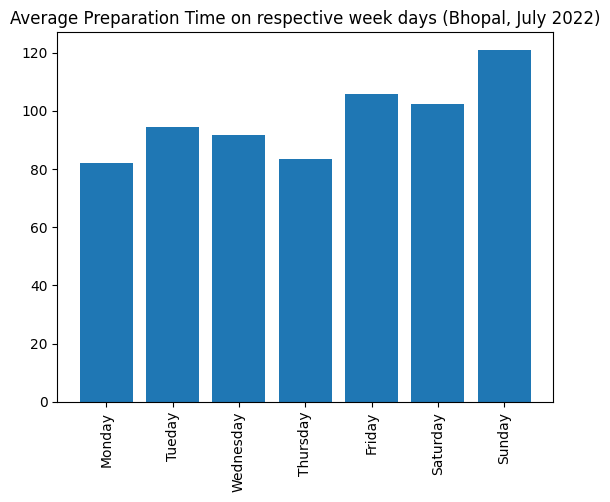

In [200]:
from matplotlib import pyplot
x = ['Monday', 'Tueday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
y = [a[1], a[2], a[3], a[4], a[5], a[6], a[7]]
pyplot.bar(x, y)
pyplot.xticks(rotation=90)
pyplot.title("Average Preparation Time on respective week days (Bhopal, July 2022)")
pyplot.show()

In [202]:
a = {}
for ts in allTimeslots:
    print(ts)
    avgPrepTime = mean(overallDF.loc[overallDF['feature_3'] == ts].prep_time.values.tolist())
    a[ts] = avgPrepTime

1.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0


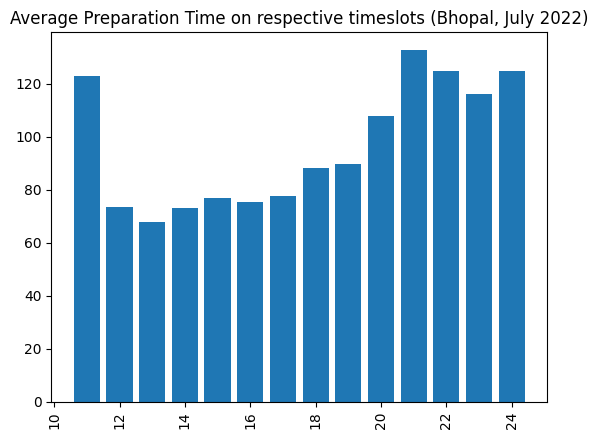

In [205]:
from matplotlib import pyplot
x = [i for i in range(11, 25)]
y = [a[i] for i in range(11, 25)]
pyplot.bar(x, y)
pyplot.xticks(rotation=90)
pyplot.title("Average Preparation Time on respective timeslots (Bhopal, July 2022)")
pyplot.show()

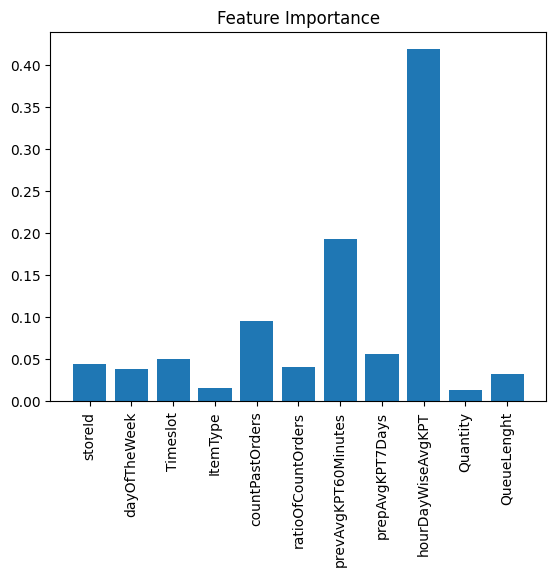

0.9999999087303877


In [226]:
from matplotlib import pyplot
f = ['storeId', 'dayOfTheWeek', 'Timeslot', 'ItemType', 'countPastOrders', 'ratioOfCountOrders', 'prevAvgKPT60Minutes', 'prepAvgKPT7Days', 'hourDayWiseAvgKPT', 'Quantity', 'QueueLenght']
pyplot.bar(f, best_regressor.feature_importances_)
pyplot.xticks(rotation=90)
pyplot.title("Feature Importance")
pyplot.show()
print(sum(best_regressor.feature_importances_))

In [ ]:
# Experiment 1
# remove feature with feature value less than 0.05
# Remaining Features : 1,2,3,5,7,8,9
totalFeatures = (1 +  # store ID (categorical)
                 1 +  # day of the week (categorical)
                 1 +  #timeslot of the day (categorical)
                 1 +  #count past orders in last 30 minutes
                 1 +  # average previous preparation time in last 1 hour
                 1 +  # average previous preparation time in last 7 days
                 1  # average kpt time, hour wise according to the day of the week
                 )  # length of the current queue

feature_cols = []
for i in range(0, totalFeatures):
    feature_cols.append('feature_' + str(i + 1))
# TIME CONSUMING (3m 21s for Bhopal)
for storeId in restWiseDFs:
    X = []
    df = restWiseDFs[storeId]
    for index, item in df.iterrows():
        features = getStoreId(item, False)
        features += dayOfTheWeek(item['Kitchen_Display_Time'], isOneHotEncodingRequired)
        features += getTimeSlotOfKitchenDisplayTime(item, isOneHotEncodingRequired)
        # features += getItemType(item, clubItemsCategoryWise, isOneHotEncodingRequired)
        features += [countPastOrders(item, slotTimeForPastOrders)]
        # features += [getLiftInOrders(item, slotTimeForPastOrders)]
        features += [getPreviousPrepTime(item, timeslot=60)]
        features += [getPreviousPrepTime(item, timeslot=7 * 24 * 60)]
        features += [getHourWiseAverage(item)]
        # features += [getQuantity(item)]
        # features += [lengthQueue(item)]
        X.append(features)
    Xnp = np.array(X)
    updateFeatures(storeId, Xnp)
    print(Xnp.shape)
# categorical data
if not isOneHotEncodingRequired:
    for i in range(0, 4):
        for storeId in allStoreIds:
            restWiseDFs[storeId][feature_cols[i]] = restWiseDFs[storeId][feature_cols[i]].astype("category")
restWiseScalers = {}

# normalize feature values
if isNormalizationRequired:
    for storeId in allStoreIds:
        firstTime = datetime(2022, 7, 1)
        lastTime = datetime(2022, 7, 14)
        trainingData = restWiseDFs[storeId].loc[(restWiseDFs[storeId]['Kitchen_Display_Time'] >= firstTime) & \
                                                (restWiseDFs[storeId]['Kitchen_Display_Time'] <= lastTime)].loc[:,
                       feature_cols]
        scaler = StandardScaler()
        scaler.fit(trainingData)
        if isNormalizationRequired:
            X = restWiseDFs[storeId].loc[:, feature_cols]
            X_scaled = scaler.transform(X)
            X_scalednp = np.array(X_scaled)
            updateFeatures(storeId, X_scalednp)
    save_object(restWiseDFs, f'restWiseDFsWithNormalizedFeatures{city}.pkl')


if isCentralModel:
    overallDF = pd.DataFrame()
    for storeId in allStoreIds:
        overallDF = pd.concat([overallDF, restWiseDFs[storeId]], ignore_index=True)
    firstTime = datetime(2022, 7, 1)
    lastTime = datetime(2022, 7, 14)
    trainingData = overallDF.loc[(overallDF['Kitchen_Display_Time'] >= firstTime) & \
                                 (overallDF['Kitchen_Display_Time'] <= lastTime)]
    X_train = trainingData.loc[:, feature_cols]
    y_train = trainingData.prep_time.values.tolist()

    firstTime = datetime(2022, 7, 15)
    lastTime = datetime(2022, 7, 21)
    validationData = overallDF.loc[(overallDF['Kitchen_Display_Time'] >= firstTime) & \
                                   (overallDF['Kitchen_Display_Time'] <= lastTime)]

    X_train_val = validationData.loc[:, feature_cols]
    y_train_val = validationData.prep_time.values.tolist()

    firstTime = datetime(2022, 7, 22)
    lastTime = datetime(2022, 7, 31)
    testData = overallDF.loc[(overallDF['Kitchen_Display_Time'] >= firstTime) & \
                             (overallDF['Kitchen_Display_Time'] <= lastTime)]

    X_test = testData.loc[:, feature_cols]
    y_test = testData.prep_time.values.tolist()

    regressor = XGBRegressor()
    param_grid = {
        'tree_method': ['approx', 'hist'],
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7, 10, 12, 14],
        'learning_rate': [0.2, 0.1, 0.01],
        'subsample': [0.6, 0.7, 0.8],
        'colsample_bytree': [0.6, 0.7, 0.8],
        'enable_categorical': [True],
    }

    # define the GridSearchCV object with the parameter grid and the XGBRegressor model
    grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=5)

    # fit the GridSearchCV object on the training set
    grid_search.fit(X_train, y_train)

    # print the best hyperparameters and the corresponding mean cross-validated score
    print("Best hyperparameters:", grid_search.best_params_)
    print("Best mean cross-validated score:", grid_search.best_score_)

    # retrain the model on the combined training and validation sets with the best hyperparameters
    best_regressor = XGBRegressor(**grid_search.best_params_)
    best_regressor.fit(X_train_val, y_train_val)

    # evaluate the final model performance on the test set
    test_score = best_regressor.score(X_test, y_test)
    print("Test score:", test_score)

    # regressor.fit(X_train, y_train)
    # restWiseModelsXGB[storeId] = best_regressor

    for storeId in allStoreIds:
        X = restWiseDFs[storeId].loc[:, feature_cols]
        y = restWiseDFs[storeId].prep_time.values.tolist()
        predictions = best_regressor.predict(X)
        restWiseDFs[storeId]['predicted_prep_time_central'] = predictions

        a = getRMSE(y, predictions)
        print("RMSE score overall for store central model (30 days) " + storeId + " :  ", a)

In [ ]:

rmse1 = ((trainingData.prep_time - trainingData.predicted_prep_time_central) ** 2).mean() ** .5
rmse2 = ((trainingData.prep_time - trainingData.hour_wise_avg_kpt_of_the_day) ** 2).mean() ** .5
# hour_wise_avg_kpt_of_the_day
# rmse = ((df.prep_time - df.predicted_prep_time) ** 2).mean() ** .5
#
absError = (abs(trainingData.prep_time - trainingData.predicted_prep_time_central)).values.tolist()
absError2 = (abs(trainingData.prep_time - trainingData.hour_wise_avg_kpt_of_the_day)).values.tolist()
meanAbsError = statistics.mean(absError)
medianAbsError = statistics.median(absError)

meanAbsError2 = statistics.mean(absError2)
medianAbsError2 = statistics.median(absError2)
# stdAbsError = statistics.stdev(absError)
#
# error = (df.prep_time - df.predicted_prep_time).values.tolist()
# meanError = statistics.mean(error)
# medianError = statistics.median(error)
# stdError = statistics.stdev(error)
#
# accuracy = (((df.prep_time - df.predicted_prep_time))/(7*60+df.prep_time)).values.tolist()

In [ ]:
rmse1, rmse2, meanAbsError, meanAbsError2, medianAbsError, medianAbsError21

In [ ]:
if isCentralModel:
    overallDF = pd.DataFrame()
    for storeId in allStoreIds:
        overallDF = pd.concat([overallDF, restWiseDFs[storeId]], ignore_index=True)
    firstTime = datetime(2022, 7, 1)
    lastTime = datetime(2022, 7, 21)
    trainingData = overallDF.loc[(overallDF['Kitchen_Display_Time'] >= firstTime) & \
          (overallDF['Kitchen_Display_Time'] <= lastTime)]
    X_train = trainingData.loc[:, feature_cols]
    y_train = trainingData.prep_time.values.tolist()

    firstTime = datetime(2022, 7, 24)
    lastTime = datetime(2022, 7, 22)
    validationData = overallDF.loc[(overallDF['Kitchen_Display_Time'] >= firstTime) & \
          (overallDF['Kitchen_Display_Time'] <= lastTime)]

    X_train_val = validationData.loc[:, feature_cols]
    y_train_val = validationData.prep_time.values.tolist()

    firstTime = datetime(2022, 7, 25)
    lastTime = datetime(2022, 7, 31)
    testData = overallDF.loc[(overallDF['Kitchen_Display_Time'] >= firstTime) & \
          (overallDF['Kitchen_Display_Time'] <= lastTime)]

    X_test = testData.loc[:, feature_cols]
    y_test = testData.prep_time.values.tolist()


    regressor = XGBRegressor()
    param_grid = {
        'tree_method': ['approx', 'hist'],
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 7, 10, 13],
        'learning_rate': [0.2, 0.1, 0.01],
        'subsample': [0.6, 0.7, 0.8],
        'colsample_bytree': [0.6, 0.7, 0.8],
        'enable_categorical': [True],
    }

    # define the GridSearchCV object with the parameter grid and the XGBRegressor model
    grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=5)

    # fit the GridSearchCV object on the training set
    grid_search.fit(X_train, y_train)

    # print the best hyperparameters and the corresponding mean cross-validated score
    print("Best hyperparameters:", grid_search.best_params_)
    print("Best mean cross-validated score:", grid_search.best_score_)

    # retrain the model on the combined training and validation sets with the best hyperparameters
    best_regressor = XGBRegressor(**grid_search.best_params_)
    best_regressor.fit(X_train_val, y_train_val)

    # evaluate the final model performance on the test set
    test_score = best_regressor.score(X_test, y_test)
    print("Test score:", test_score)

    # regressor.fit(X_train, y_train)
    # restWiseModelsXGB[storeId] = best_regressor

    for storeId in allStoreIds:
        X = restWiseDFs[storeId].loc[:, feature_cols]
        y = restWiseDFs[storeId].prep_time.values.tolist()
        predictions = best_regressor.predict(X)
        restWiseDFs[storeId]['predicted_prep_time_central'] = predictions

        a = getRMSE(y, predictions)
        print("RMSE score overall for store central model (30 days) "+storeId+" :  ", a)

In [ ]:

rmse1 = ((testingData.prep_time - testingData.predicted_prep_time_central) ** 2).mean() ** .5
rmse2 = ((testingData.prep_time - testingData.hour_wise_avg_kpt_of_the_day) ** 2).mean() ** .5
# hour_wise_avg_kpt_of_the_day
# rmse = ((df.prep_time - df.predicted_prep_time) ** 2).mean() ** .5
#
absError = (abs(trainingData.prep_time - trainingData.predicted_prep_time_central)).values.tolist()
absError2 = (abs(trainingData.prep_time - trainingData.hour_wise_avg_kpt_of_the_day)).values.tolist()
meanAbsError = statistics.mean(absError)
medianAbsError = statistics.median(absError)

meanAbsError2 = statistics.mean(absError2)
medianAbsError2 = statistics.median(absError2)
# stdAbsError = statistics.stdev(absError)
#
# error = (df.prep_time - df.predicted_prep_time).values.tolist()
# meanError = statistics.mean(error)
# medianError = statistics.median(error)
# stdError = statistics.stdev(error)
#
# accuracy = (((df.prep_time - df.predicted_prep_time))/(7*60+df.prep_time)).values.tolist()

In [ ]:
# Time Consuming (training on first 14 days of July)
restWiseModelsXGB = {}

for storeId in allStoreIds:
    firstTime = datetime(2022, 7, 1)
    lastTime = datetime(2022, 7, 14)
    trainingData = restWiseDFs[storeId].loc[(restWiseDFs[storeId]['Kitchen_Display_Time'] >= firstTime) & \
          (restWiseDFs[storeId]['Kitchen_Display_Time'] <= lastTime)]
    
    X_train = trainingData.loc[:, feature_cols]
    y_train = trainingData.prep_time.values.tolist()

    firstTime = datetime(2022, 7, 15)
    lastTime = datetime(2022, 7, 21)
    validationData = restWiseDFs[storeId].loc[(restWiseDFs[storeId]['Kitchen_Display_Time'] >= firstTime) & \
          (restWiseDFs[storeId]['Kitchen_Display_Time'] <= lastTime)]

    X_train_val = validationData.loc[:, feature_cols]
    y_train_val = validationData.prep_time.values.tolist()

    firstTime = datetime(2022, 7, 22)
    lastTime = datetime(2022, 7, 31)
    testData = restWiseDFs[storeId].loc[(restWiseDFs[storeId]['Kitchen_Display_Time'] >= firstTime) & \
          (restWiseDFs[storeId]['Kitchen_Display_Time'] <= lastTime)]

    X_test = testData.loc[:, feature_cols]
    y_test = testData.prep_time.values.tolist()


    regressor = XGBRegressor()
    # define the parameter grid to search
    param_grid = {
        'tree_method': ['approx', 'hist', 'auto'],
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 7, 10, 13],
        'learning_rate': [0.1, 0.01, 0.001],
        'subsample': [0.6, 0.7, 0.8],
        'colsample_bytree': [0.6, 0.7, 0.8],
        'enable_categorical': [True],
    }

    # define the GridSearchCV object with the parameter grid and the XGBRegressor model
    grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=5)

    # fit the GridSearchCV object on the training set
    grid_search.fit(X_train, y_train)

    # print the best hyperparameters and the corresponding mean cross-validated score
    print("Best hyperparameters:", grid_search.best_params_)
    print("Best mean cross-validated score:", grid_search.best_score_)

    # retrain the model on the combined training and validation sets with the best hyperparameters
    best_regressor = XGBRegressor(**grid_search.best_params_)
    best_regressor.fit(X_train_val, y_train_val)

    # evaluate the final model performance on the test set
    test_score = best_regressor.score(X_test, y_test)
    print("Test score:", test_score)

    # regressor.fit(X_train, y_train)
    restWiseModelsXGB[storeId] = best_regressor
    
    
    X = restWiseDFs[storeId].loc[:, feature_cols]
    y = restWiseDFs[storeId].prep_time.values.tolist()
    predictions = best_regressor.predict(X)
    restWiseDFs[storeId]['predicted_prep_time'] = predictions
    
    a = getRMSE(y, predictions)
    print("RMSE score overall for store (30 days) "+storeId+" :  ", a)

In [ ]:
save_object(restWiseDFs, f'restWiseDFsWithPredictions{city}.pkl')

In [ ]:
save_object(restWiseModelsXGB, f'restWiseModels{city}.pkl')

In [ ]:
def getPredictionHyperparameters(startDay, endDay): # both are included
    df = pd.DataFrame()
    firstTime = datetime(2022, 7, startDay)
    lastTime = datetime(2022, 7, endDay) + timedelta(days=1)
    for storeId in allStoreIds:
        df2 = restWiseDFs[storeId].loc[(restWiseDFs[storeId]['Kitchen_Display_Time'] >= firstTime) & \
          (restWiseDFs[storeId]['Kitchen_Display_Time'] < lastTime) & \
                                       (restWiseDFs[storeId]['prep_time'] != timedelta(0))]
        df = pd.concat([df, df2], ignore_index = True)
    
    rmse = ((df.prep_time - df.predicted_prep_time) ** 2).mean() ** .5
    
    absError = (abs(df.prep_time - df.predicted_prep_time)).values.tolist()
    meanAbsError = statistics.mean(absError)
    medianAbsError = statistics.median(absError)
    stdAbsError = statistics.stdev(absError)
    
    error = (df.prep_time - df.predicted_prep_time).values.tolist()
    meanError = statistics.mean(error)
    medianError = statistics.median(error)
    stdError = statistics.stdev(error)
    
    accuracy = (((df.prep_time - df.predicted_prep_time))/(7*60+df.prep_time)).values.tolist()
    for i in range(0, len(accuracy)):
        if accuracy[i] < 0:
            accuracy[i] = -1*accuracy[i]
        accuracy[i] = 1-accuracy[i]
    meanAccuracy = statistics.mean(accuracy)
    if not(meanAccuracy > 0 and meanAccuracy < 1):
        print("Mean accuracy is zero: ")
        print(meanAccuracy)
    medianAccuracy = statistics.median(accuracy)
    stdAccuracy = statistics.stdev(accuracy)
    return rmse, (meanAbsError, medianAbsError, stdAbsError), (meanError, medianError, stdError), (meanAccuracy, medianAccuracy, stdAccuracy)

In [ ]:
rmseList = []
meanAbsErrorList = []
medianAbsErrorList = []
stdAbsErrorList = []
meanErrorList = []
medianErrorList = []
stdErrorList = []
meanAccuracyList = []
medianAccuracyList = []
stdAccuracyList = []

x = [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]

for i in x:
    (rmse, (meanAbsError, medianAbsError, stdAbsError), 
    (meanError, medianError, stdError), 
    (meanAccuracy, medianAccuracy, stdAccuracy)) = getPredictionHyperparameters(i,i)
    rmseList.append(rmse)
    meanAbsErrorList.append(meanAbsError)
    medianAbsErrorList.append(medianAbsError)
    stdAbsErrorList.append(stdAbsError)
    meanErrorList.append(meanError)
    medianErrorList.append(medianError)
    stdErrorList.append(stdError)
    meanAccuracyList.append(meanAccuracy)
    medianAccuracyList.append(medianAccuracy)
    stdAccuracyList.append(stdAccuracy)

In [ ]:
# plot for 15, 20, 25, 30 july 
plt.bar(x, rmseList)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("RMSE value on the respective day")
plt.title("Model predictions with days")
plt.savefig(f'{city}_1.png')

In [ ]:
# plot for 15, 20, 25, 30 july 
plt.bar(x, medianAbsErrorList)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("Absolute Value of error (median) on the respective day")
plt.title("Model predictions with days")
plt.savefig(f'{city}_3.png')

In [ ]:
# plot for 15, 20, 25, 30 july 
plt.errorbar(x, meanErrorList, stdErrorList)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("error (mean, std dev of the day) on the respective day")
plt.title("Model predictions with days")
plt.savefig(f'{city}_4.png')

In [ ]:
# plot for 15, 20, 25, 30 july 
plt.bar(x, medianErrorList)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("error (median) on the respective day")
plt.title("Model predictions with days")
plt.savefig(f'{city}_5.png')

In [ ]:
# plot for 15, 20, 25, 30 july 
plt.errorbar(x, meanAccuracyList, stdAccuracyList)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("Accuracy (mean, std dev of the day) on the respective day")
plt.title("Model predictions with days")
plt.savefig(f'{city}_6.png')



In [ ]:
overallDf = pd.DataFrame()
for storeId in allStoreIds:
        overallDf = pd.concat([overallDf, restWiseDFs[storeId]], ignore_index = True)

In [ ]:
a = overallDf.loc[(overallDf['Oven_Time'] - overallDf['Kitchen_Display_Time'] < timedelta(seconds=1))]

In [ ]:
a

In [ ]:
# plot for 15, 20, 25, 30 july 
plt.ylim(0.8, 1)
plt.bar(x, medianAccuracyList)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("Accuracy (median) on the respective day")
plt.title("Model predictions with days")
plt.savefig(f'{city}_7.png')


In [ ]:
# baseline approach
# Hourwise avg 

weekdayHourWiseAvg = {}
weekendHourWiseAvg = {}
for store in allStoreIds:
    weekdayHourWiseAvg[store] = {}
    weekendHourWiseAvg[store] = {}
for i in range(1, 15):
    dt = datetime(2022, 7, i)
    for storeId in allStoreIds:
        df = restWiseDFs[storeId].loc[(restWiseDFs[storeId]['Kitchen_Display_Time'] >= dt) & \
          (restWiseDFs[storeId]['Kitchen_Display_Time'] < dt+timedelta(days=1))]
        for index, item in df.iterrows():
            ts = getTimeslot(item['Kitchen_Display_Time'])
            if(dayOfTheWeek(item['Kitchen_Display_Time']) >= 5):
                if ts not in weekendHourWiseAvg[storeId]:
                    weekendHourWiseAvg[storeId][ts] = {'val': 0, 'cnt': 0}
                weekendHourWiseAvg[storeId][ts]['val'] += item['prep_time']
                weekendHourWiseAvg[storeId][ts]['cnt'] += 1
            else:
                if ts not in weekdayHourWiseAvg[storeId]:
                    weekdayHourWiseAvg[storeId][ts] = {'val': 0, 'cnt': 0}
                weekdayHourWiseAvg[storeId][ts]['val'] += item['prep_time']
                weekdayHourWiseAvg[storeId][ts]['cnt'] += 1

for storeId in allStoreIds:
    for ts in weekdayHourWiseAvg[storeId].keys():
        weekdayHourWiseAvg[storeId][ts]['val'] = weekdayHourWiseAvg[storeId][ts]['val']/weekdayHourWiseAvg[storeId][ts]['cnt']
    for ts in weekendHourWiseAvg[storeId].keys():
        weekendHourWiseAvg[storeId][ts]['val'] = weekendHourWiseAvg[storeId][ts]['val']/weekendHourWiseAvg[storeId][ts]['cnt']
        

        
        

In [ ]:
overallDF = pd.DataFrame()
for storeId in allStoreIds:
    overallDF = pd.concat([overallDF, restWiseDFs[storeId]], ignore_index = True)

In [ ]:
avgs = []
for index, item in overallDF.iterrows():
    ts = getTimeslot(item['Kitchen_Display_Time'])
    storeId = item['Location_Code']
    if(dayOfTheWeek(item['Kitchen_Display_Time']) >= 5):
        if(ts not in weekendHourWiseAvg[storeId]):
            avgs.append(0)
        else:
            avgs.append(weekendHourWiseAvg[storeId][ts]['val'] )
    else:
        if(ts not in weekdayHourWiseAvg[storeId]):
            avgs.append(0)
        else:
            avgs.append(weekdayHourWiseAvg[storeId][ts]['val'] )


In [ ]:
overallDF['hourwise_avg'] = avgs

In [ ]:
restWiseDFs = {}
for storeId in allStoreIds:
    restWiseDFs[storeId] = overallDF.loc[overallDF['Location_Code'] == storeId]

In [ ]:
def getBaselineHyperparameters(startDay, endDay): # both are included
    df = pd.DataFrame()
    firstTime = datetime(2022, 7, startDay)
    lastTime = datetime(2022, 7, endDay) + timedelta(days=1)
    for storeId in allStoreIds:
        df2 = restWiseDFs[storeId].loc[(restWiseDFs[storeId]['Kitchen_Display_Time'] >= firstTime) & \
          (restWiseDFs[storeId]['Kitchen_Display_Time'] < lastTime)]
        df = pd.concat([df, df2], ignore_index = True)
    
    rmse = ((df.prep_time - df.hourwise_avg) ** 2).mean() ** .5
    
    absError = (abs(df.prep_time - df.hourwise_avg)).values.tolist()
    meanAbsError = statistics.mean(absError)
    medianAbsError = statistics.median(absError)
    stdAbsError = statistics.stdev(absError)
    
    error = (df.prep_time - df.hourwise_avg).values.tolist()
    meanError = statistics.mean(error)
    medianError = statistics.median(error)
    stdError = statistics.stdev(error)
    
    accuracy = ((df.prep_time - abs(df.prep_time - df.hourwise_avg))/df.prep_time).values.tolist()
    meanAccuracy = statistics.mean(accuracy)
    medianAccuracy = statistics.median(accuracy)
    stdAccuracy = statistics.stdev(accuracy)
    return rmse, (meanAbsError, medianAbsError, stdAbsError), (meanError, medianError, stdError), (meanAccuracy, medianAccuracy, stdAccuracy)

In [ ]:
rmseListBL = []
meanAbsErrorListBL = []
medianAbsErrorListBL = []
stdAbsErrorListBL = []
meanErrorListBL = []
medianErrorListBL = []
stdErrorListBL = []
meanAccuracyListBL = []
medianAccuracyListBL = []
stdAccuracyListBL = []

x = [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]

for i in x:
    (rmse, (meanAbsError, medianAbsError, stdAbsError), 
    (meanError, medianError, stdError), 
    (meanAccuracy, medianAccuracy, stdAccuracy)) = getBaselineHyperparameters(i,i)
    rmseListBL.append(rmse)
    meanAbsErrorListBL.append(meanAbsError)
    medianAbsErrorListBL.append(medianAbsError)
    stdAbsErrorListBL.append(stdAbsError)
    meanErrorListBL.append(meanError)
    medianErrorListBL.append(medianError)
    stdErrorListBL.append(stdError)
    meanAccuracyListBL.append(meanAccuracy)
    medianAccuracyListBL.append(medianAccuracy)
    stdAccuracyListBL.append(stdAccuracy)

In [ ]:
# plot for 15, 20, 25, 30 july 
plt.bar(x, rmseListBL)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("RMSE value on the respective day")
plt.title("Baseline prediction")
plt.savefig(f'BL_{city}_1.png')

In [ ]:
rmseListBL

In [ ]:
# plot for 15, 20, 25, 30 july 
plt.bar(x, medianAbsErrorListBL)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("Absolute Value of error (median) on the respective day")
plt.title("Baseline Prediction")
plt.savefig(f'BL_{city}_3.png')

In [ ]:
# plot for 15, 20, 25, 30 july 
plt.errorbar(x, meanErrorListBL, stdErrorListBL)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("error (mean, std dev of the day) on the respective day")
plt.title("Baseline Prediction")
plt.savefig(f'BL_{city}_4.png')

In [ ]:
# plot for 15, 20, 25, 30 july 
plt.bar(x, medianErrorListBL)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("error (median) on the respective day")
plt.title("Baseline Prediction")
plt.savefig(f'BL_{city}_5.png')

In [ ]:
# plot for 15, 20, 25, 30 july 
plt.errorbar(x, meanAccuracyListBL, stdAccuracyListBL)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("Accuracy (mean, std dev of the day) on the respective day")
plt.title("Baseline Prediction")
plt.savefig(f'BL_{city}_6.png')



In [ ]:
# plot for 15, 20, 25, 30 july 
plt.ylim(0.7, 1)
plt.bar(x, medianAccuracyListBL)
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("Accuracy (median) on the respective day")
plt.title("Baseline Prediction")
plt.savefig(f'BL_{city}_7.png')


In [ ]:
(rmseTr, (meanAbsErrorTr, medianAbsErrorTr, stdAbsErrorTr), 
    (meanErrorTr, medianErrorTr, stdErrorTr), 
    (meanAccuracyTr, medianAccuracyTr, stdAccuracyTr)) = getPredictionHyperparameters(1, 14)

In [ ]:
(rmseTe, (meanAbsErrorTe, medianAbsErrorTe, stdAbsErrorTe), 
    (meanErrorTe, medianErrorTe, stdErrorTe), 
    (meanAccuracyTe, medianAccuracyTe, stdAccuracyTe)) = getPredictionHyperparameters(15, 31)

In [ ]:
(rmseTr, (meanAbsErrorTr, medianAbsErrorTr, stdAbsErrorTr), 
    (meanErrorTr, medianErrorTr, stdErrorTr), 
    (meanAccuracyTr, medianAccuracyTr, stdAccuracyTr))

In [ ]:
(rmseTe, (meanAbsErrorTe, medianAbsErrorTe, stdAbsErrorTe), 
    (meanErrorTe, medianErrorTe, stdErrorTe), 
    (meanAccuracyTe, medianAccuracyTe, stdAccuracyTe))

In [ ]:
x = [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
plt.plot(x, rmseList, label="xgboost model")
plt.plot(x, rmseListBL, label='baseline')
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("RMSE Comparison on the respective day")
plt.title("Model vs Baseline in RMSE values")
plt.legend()
plt.savefig(f'BL_{city}_7.png')


In [ ]:
x = [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
plt.plot(x, medianAbsErrorList, label="xgboost model")
plt.plot(x, medianAbsErrorListBL, label='baseline')
plt.xticks(x)
plt.xlabel("Date")
plt.ylabel("Median Abs Error Comparison on the respective day")
plt.title("Model vs Baseline in Median Abs Error")
plt.legend()
plt.savefig(f'BL_{city}_8.png')

In [ ]:
def getErrorSlot(error):
    return (error//5)*5

cnt = {}
for index, item in overallDF.iterrows():
    error = (item['prep_time'] - item['predicted_prep_time'])/60
    lts = getErrorSlot(error)
    if(lts not in cnt):
        cnt[lts]=1
    else:
        cnt[lts]+=1

In [ ]:
ranges = sorted(cnt.keys())

In [ ]:
cnt[-10]

In [ ]:
cnt[-5]

In [ ]:
cnt[0]

In [ ]:
for i in range(-)